In [1]:
from env import navigation_env
import os
import matplotlib.pyplot as plt
import numpy as np
from igraph import Graph
from matplotlib import colors
from typing import List

In [2]:
def generate_map(rows: int, cols: int, obstacles_perc: int, jump_perc: int = 25, shuffle_edges: bool = True) -> np.array:
    '''
    Generate a map with the given dimensions and obstacles percentage.

    Args:
        rows (int): Number of rows of the map.
        cols (int): Number of columns of the map.
        obstacles_perc (int): Percentage of obstacles in the map.
        jump_perc (int): Probability of taking a random node while building 
                         the map. Higher values will make the obstacles more 
                         grouped. Default is 25.
        shuffle_edges (bool): Whether to shuffle the edges of the graph while
                              building the map. Default is True. 
    
    Returns:
        np.array: A 2D array representing the map. 0 means the cell is
                    crossable, 1 means it is an obstacle.
    '''
    obs = np.ceil(obstacles_perc * rows * cols/100)
    edges = []
    for i in range(rows):
        for j in range(cols):
            node_id = i * cols + j
            if i != 0:
                edges.append((node_id, node_id - cols))
            if j != 0:
                edges.append((node_id, node_id - 1))
    g = Graph(edges=edges, directed=False)
    g = walk_graph(g, obs, jump_perc, shuffle_edges)
    return create_map(g, rows, cols)


def walk_graph(g : Graph, obs: int, jump_perc: int = 25, shuffle_edges: bool = True) -> Graph:
    '''
    Creates the crossable nodes of the map by walking the graph.

    Args:  
        g (Graph): The graph representing the map.
        obs (int): Number of obstacles to be placed in the map.
        jump_perc (int): Probability of taking a random node while building
                         the map. Higher values will make the obstacles more
                         grouped. Default is 25.
        shuffle_edges (bool): Whether to shuffle the edges of the graph while
                              building the map. Default is True.

    Returns:
        Graph: The graph with the crossable nodes. The crossable nodes are
                marked with the attribute 'crossable' set to True.
    '''
    count = 0
    source = np.random.choice(range(0, g.vcount()), 1, replace=False)
    available_nodes = source.tolist()
    
    while count < g.vcount() - obs:
        if np.random.rand() <= jump_perc/100:
            current_node = np.random.choice(available_nodes, 1)[0]
        else:
            current_node = available_nodes[-1]
        g.vs[current_node]['crossable'] = True
        available_nodes.remove(current_node)
        count += 1
        #print(f'Visiting node {current_node}, {count} nodes visited.')
        available_edegs = g.incident(current_node)
        if shuffle_edges:
            np.random.shuffle(available_edegs)
        for e in available_edegs:
            e = g.es[e]
            new_node = e.target if e.source == current_node else e.source
            if not g.vs[new_node]['crossable'] and new_node not in available_nodes:
                available_nodes.append(new_node)
        #print(f'Available nodes: {available_nodes}')

    return g


def create_map(g: Graph, rows: int, cols: int) -> np.array:
    '''
    Creates a map from the crossable nodes of the graph.

    Args:
        g (Graph): The graph representing the map.
        rows (int): Number of rows of the map.
        cols (int): Number of columns of the map.
    
    Returns:
        np.array: A 2D array representing the map. 0 means the cell is
                    crossable, 1 means it is an obstacle.
    '''
    map = [0 if g.vs[i]['crossable'] else 1 for i in range(g.vcount())]
    return np.array(map).reshape(rows, cols)

In [3]:
map = generate_map(3, 3, 10)

In [4]:
print(map)

[[0 0 0]
 [1 0 0]
 [0 0 0]]


In [5]:
unique_maps = set()
maps_list = []
for i in range(300):
    size = len(unique_maps)
    map = generate_map(10, 10, 10)
    unique_maps.add(tuple(map.flatten()))
    if len(unique_maps) > size:
        maps_list.append(map)
print(len(maps_list))

300


In [6]:
def print_maps(maps_list: List[np.array], save_img_path = None) -> None:
    rows = int(np.ceil(np.sqrt(len(maps_list))))
    fig, axs = plt.subplots(rows, rows, figsize=(20, 20))
    cmap = colors.ListedColormap(['white','black'])
    for i in range(rows**2):
        axs[i//rows, i%rows].axis('off')
        if i < len(maps_list):
            axs[i//rows, i%rows].pcolor(maps_list[i], cmap=cmap, edgecolors='gray', linewidths=1)
    plt.tight_layout()
    if save_img_path is not None:
        fig.savefig(save_img_path)
    plt.show()


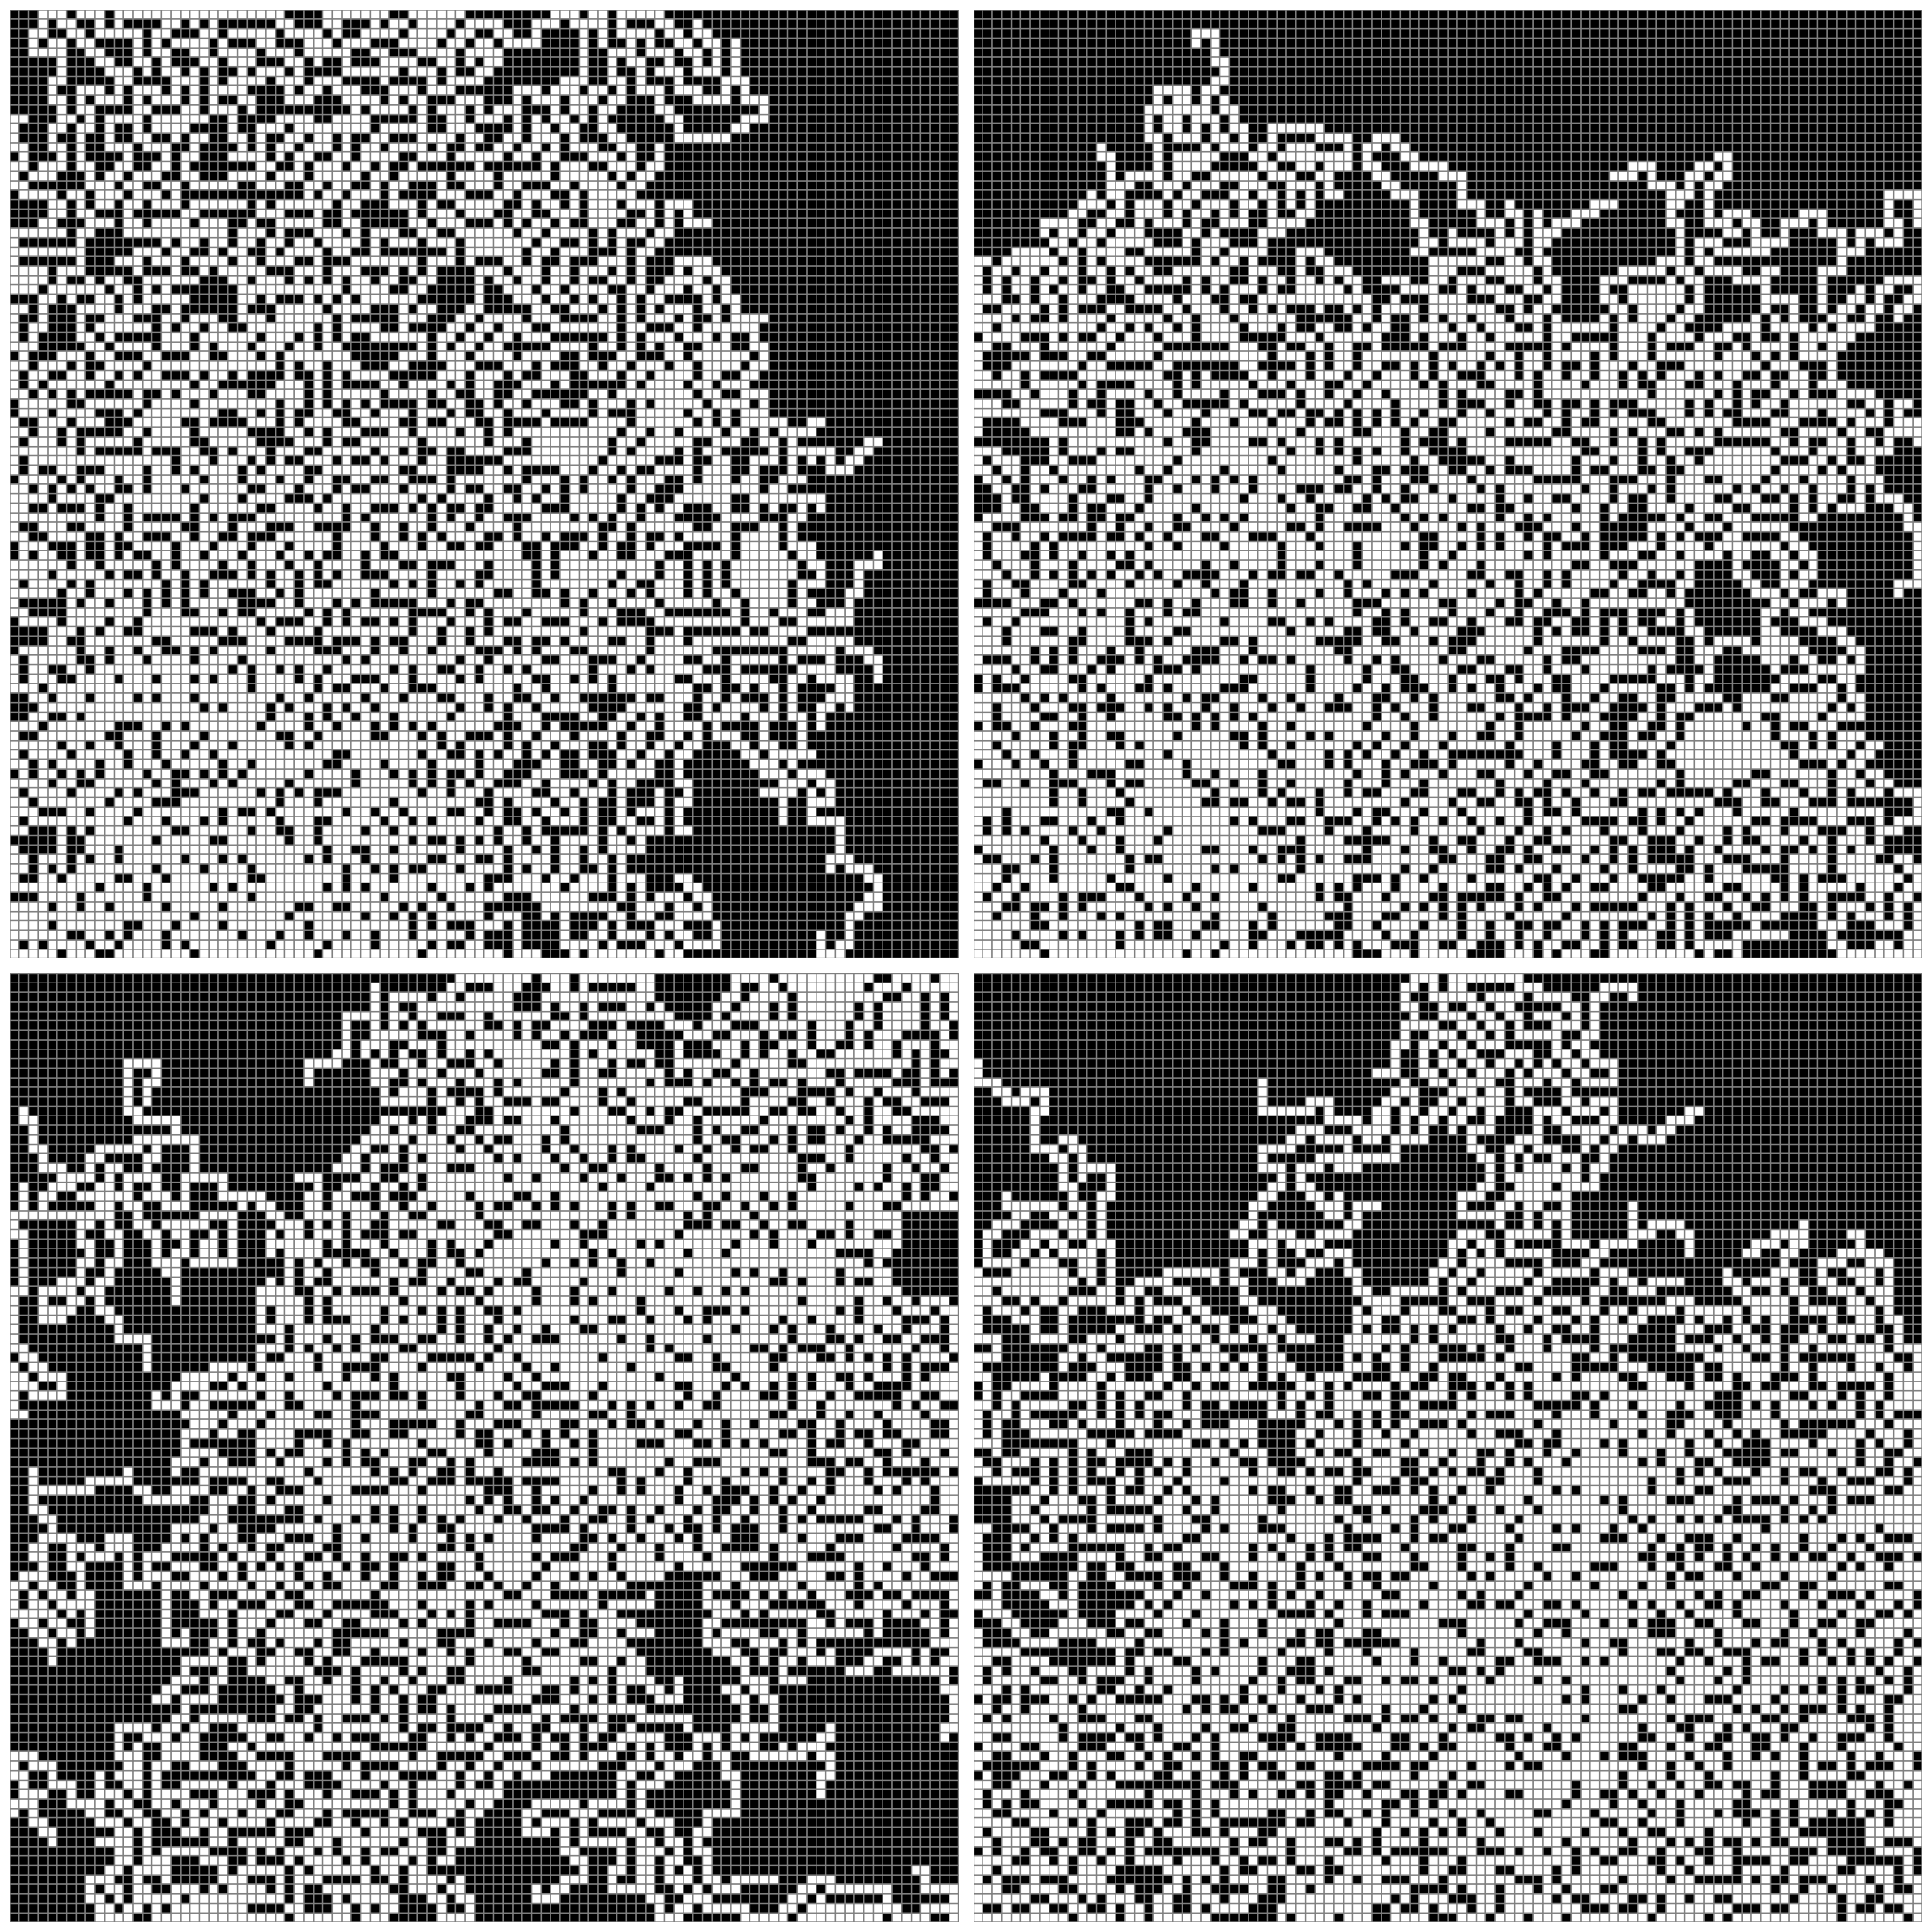

In [7]:
maps_list = []
for i in range(4):
    map = generate_map(100, 100, 50, jump_perc=20)
    maps_list.append(map)
print_maps(maps_list, None)

In [8]:
def convert_map(map: np.ndarray, source: int, target: int):
        rows, cols = map.shape
        indent = '    '
        with open('../data/map_problem_test.pddl', 'w') as f:
            s = '(define (problem p01) (:domain map)\n\n'
            s += f'(:objects\n{indent}'
            for i in range(rows):
                for j in range(cols):
                    s += f'c{i*cols+j} '
            s += '- cell\n'
            s += f'{indent}a - agent\n'
            s += ')\n\n\n'
            s += '(:init\n'
            for i in range(rows):
                for j in range(cols):
                    if i > 0:
                        if map[i, j] == 0 and map[i-1, j] == 0:
                            s += f'{indent}(is_up c{(i-1)*cols+j} c{i*cols+j})\n'
                            s += f'{indent}(is_down c{i*cols+j} c{(i-1)*cols+j})\n'
                    if j > 0:
                        if map[i, j] == 0 and map[i, j-1] == 0:
                            s += f'{indent}(is_left c{i*cols+j-1} c{i*cols+j})\n'
                            s += f'{indent}(is_right c{i*cols+j} c{i*cols+j-1})\n'
            s += f'{indent}(in a c{source})\n'
            s += f')\n\n\n'
            s += '(:goal (and\n'
            s += f'{indent}(in a c{target})\n'
            s += '))\n'
            s += ')'
        print(s)

In [2]:
from map_utils import Map, plot_maps
import json

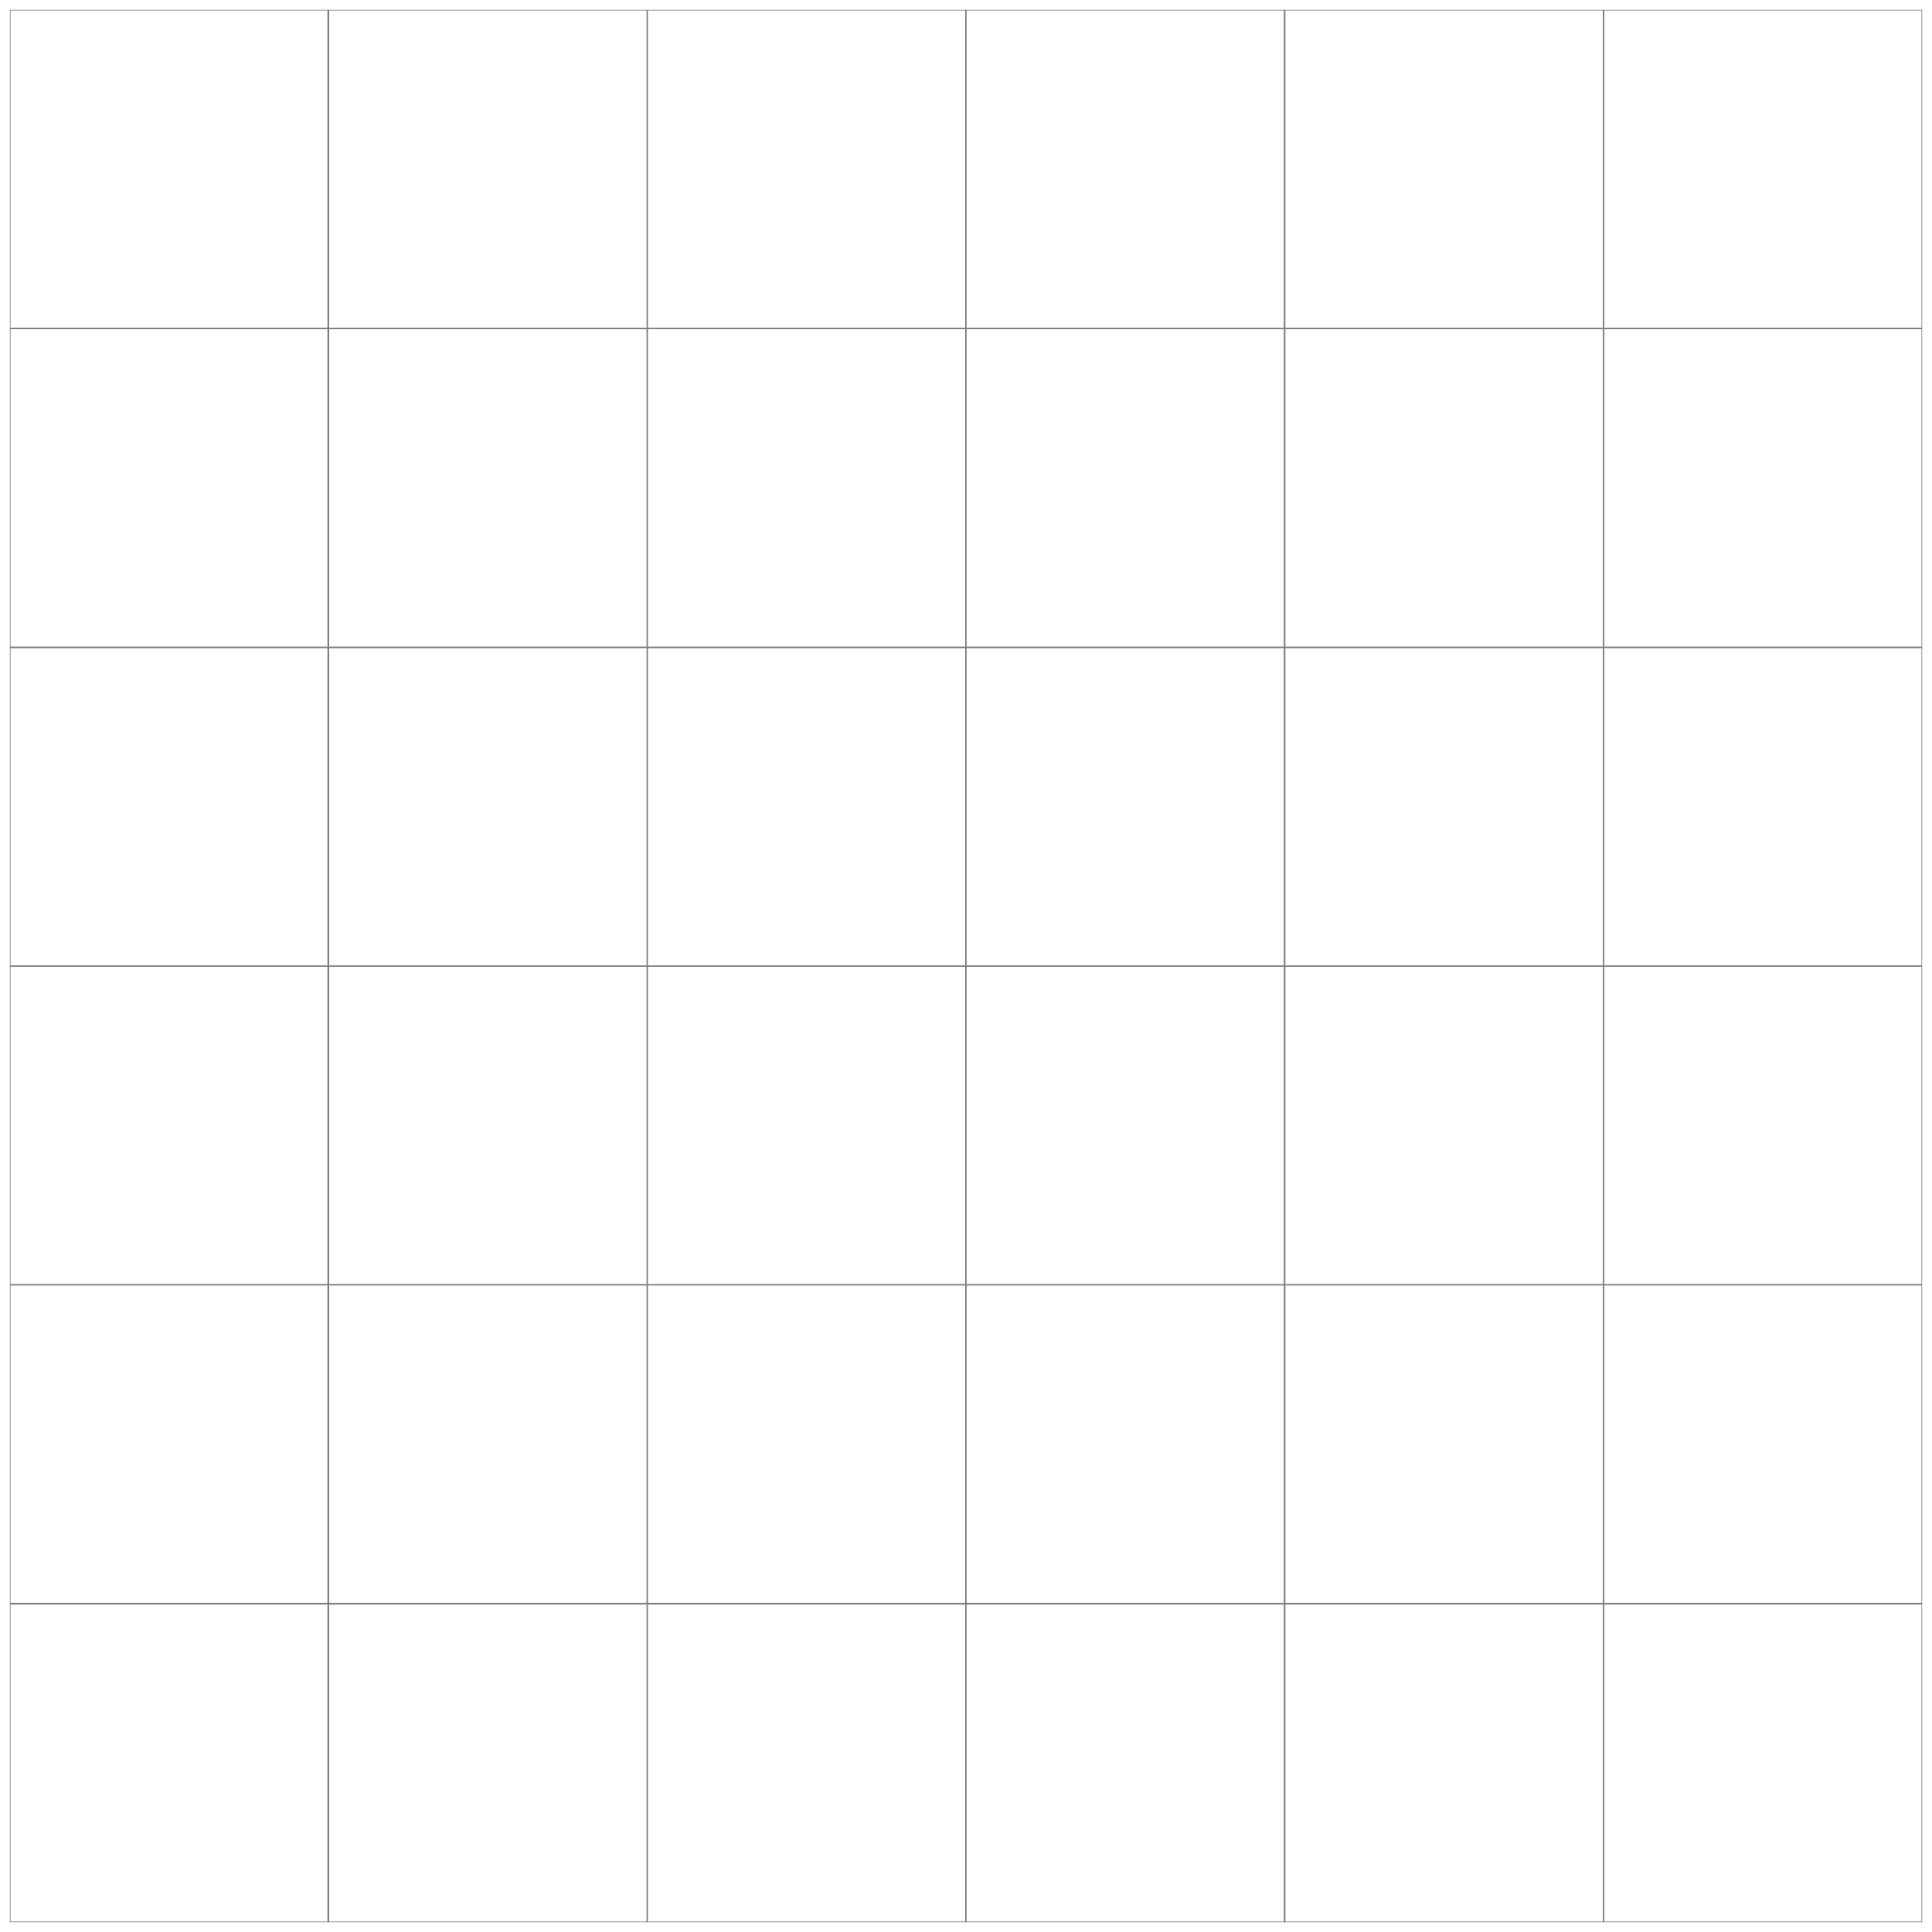

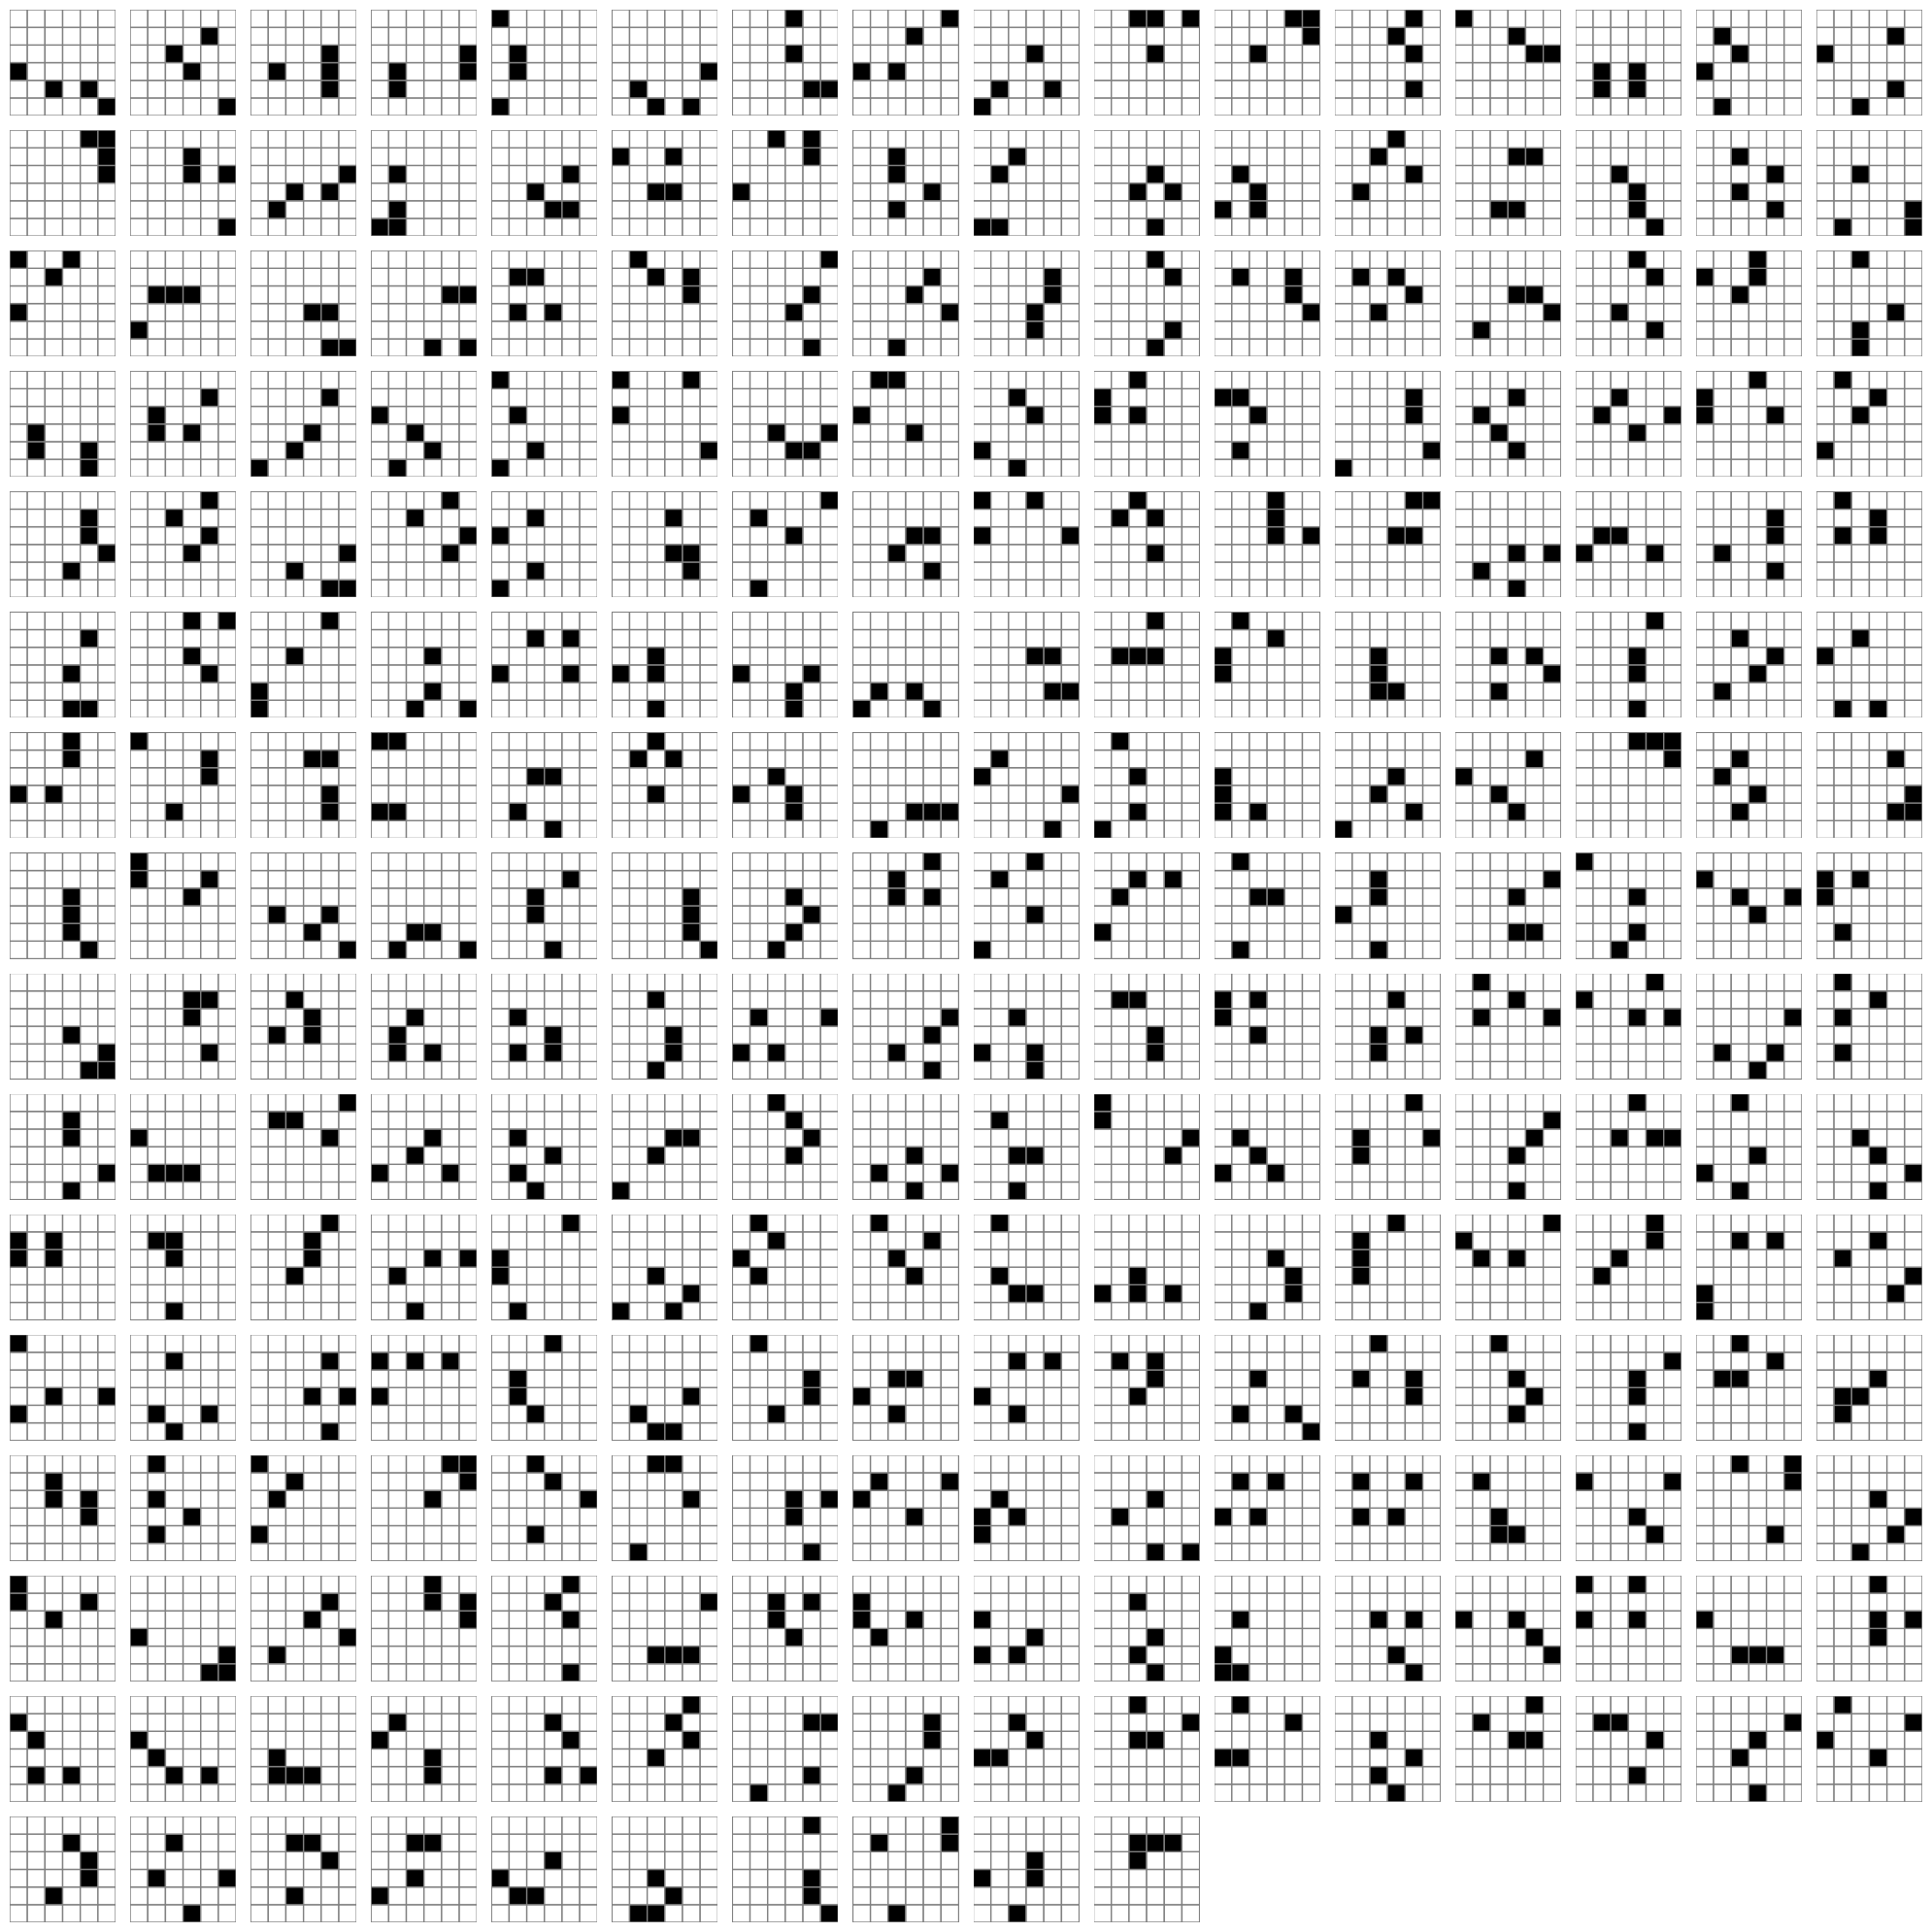

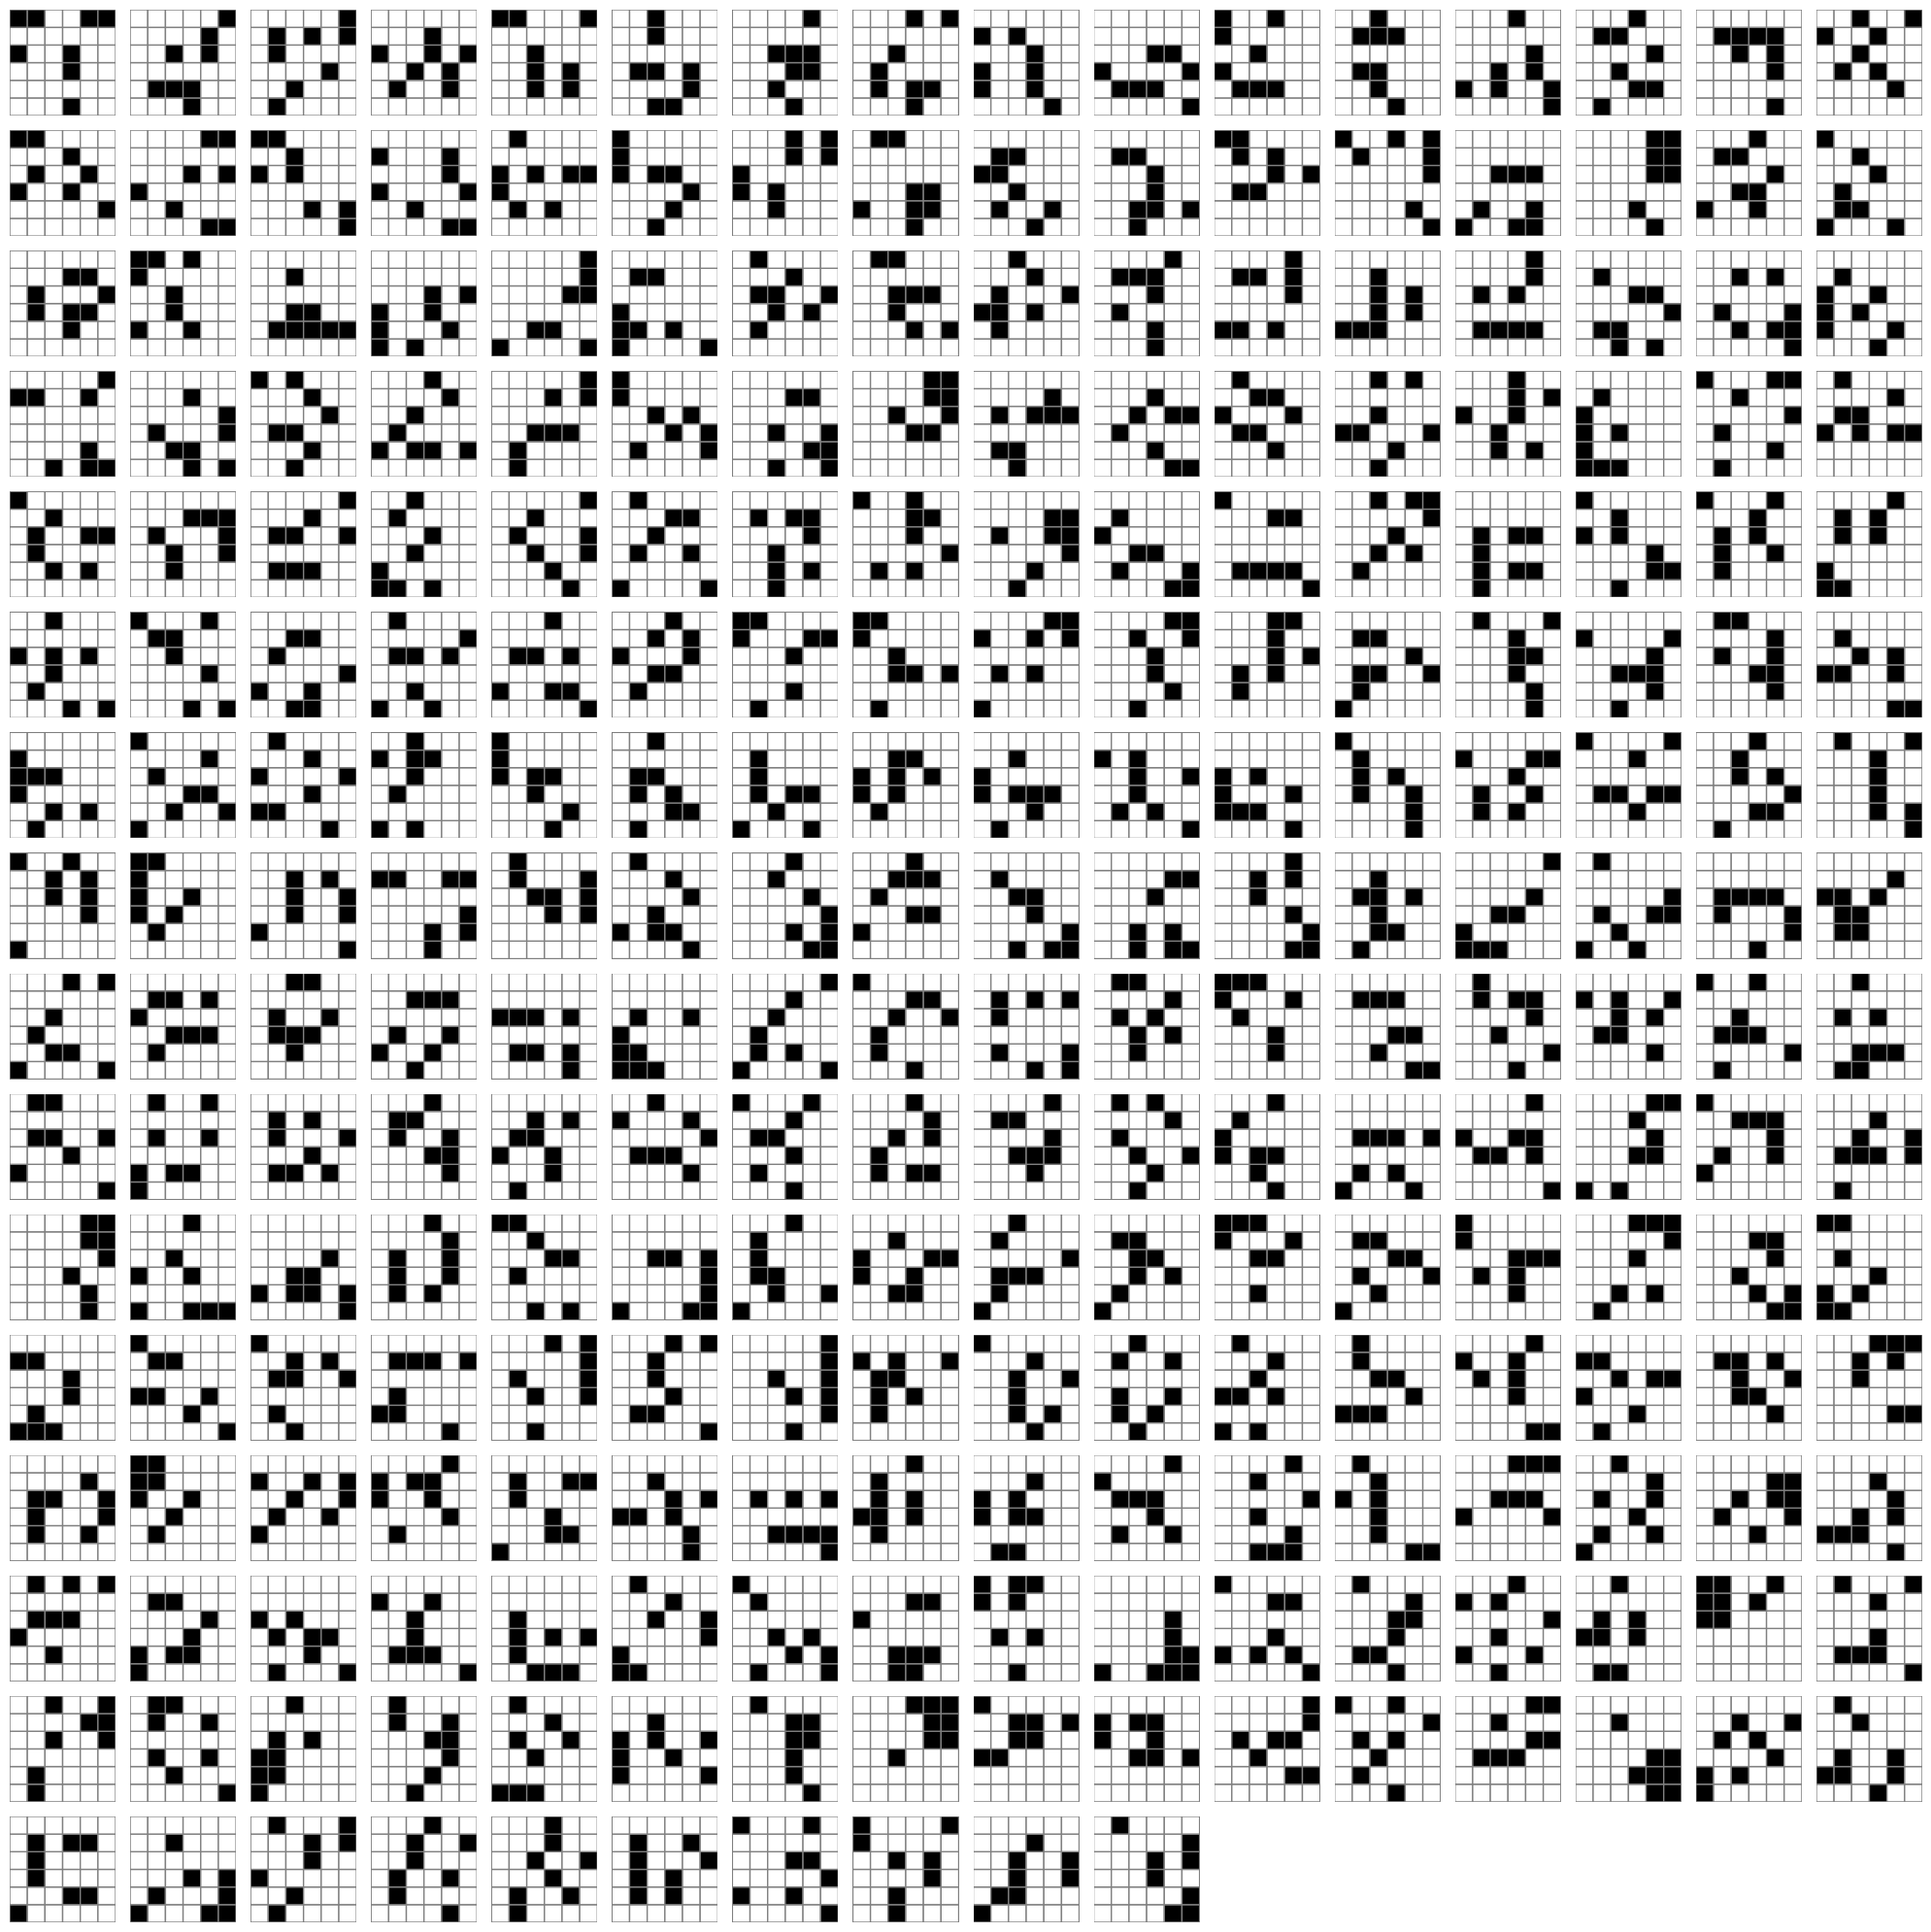

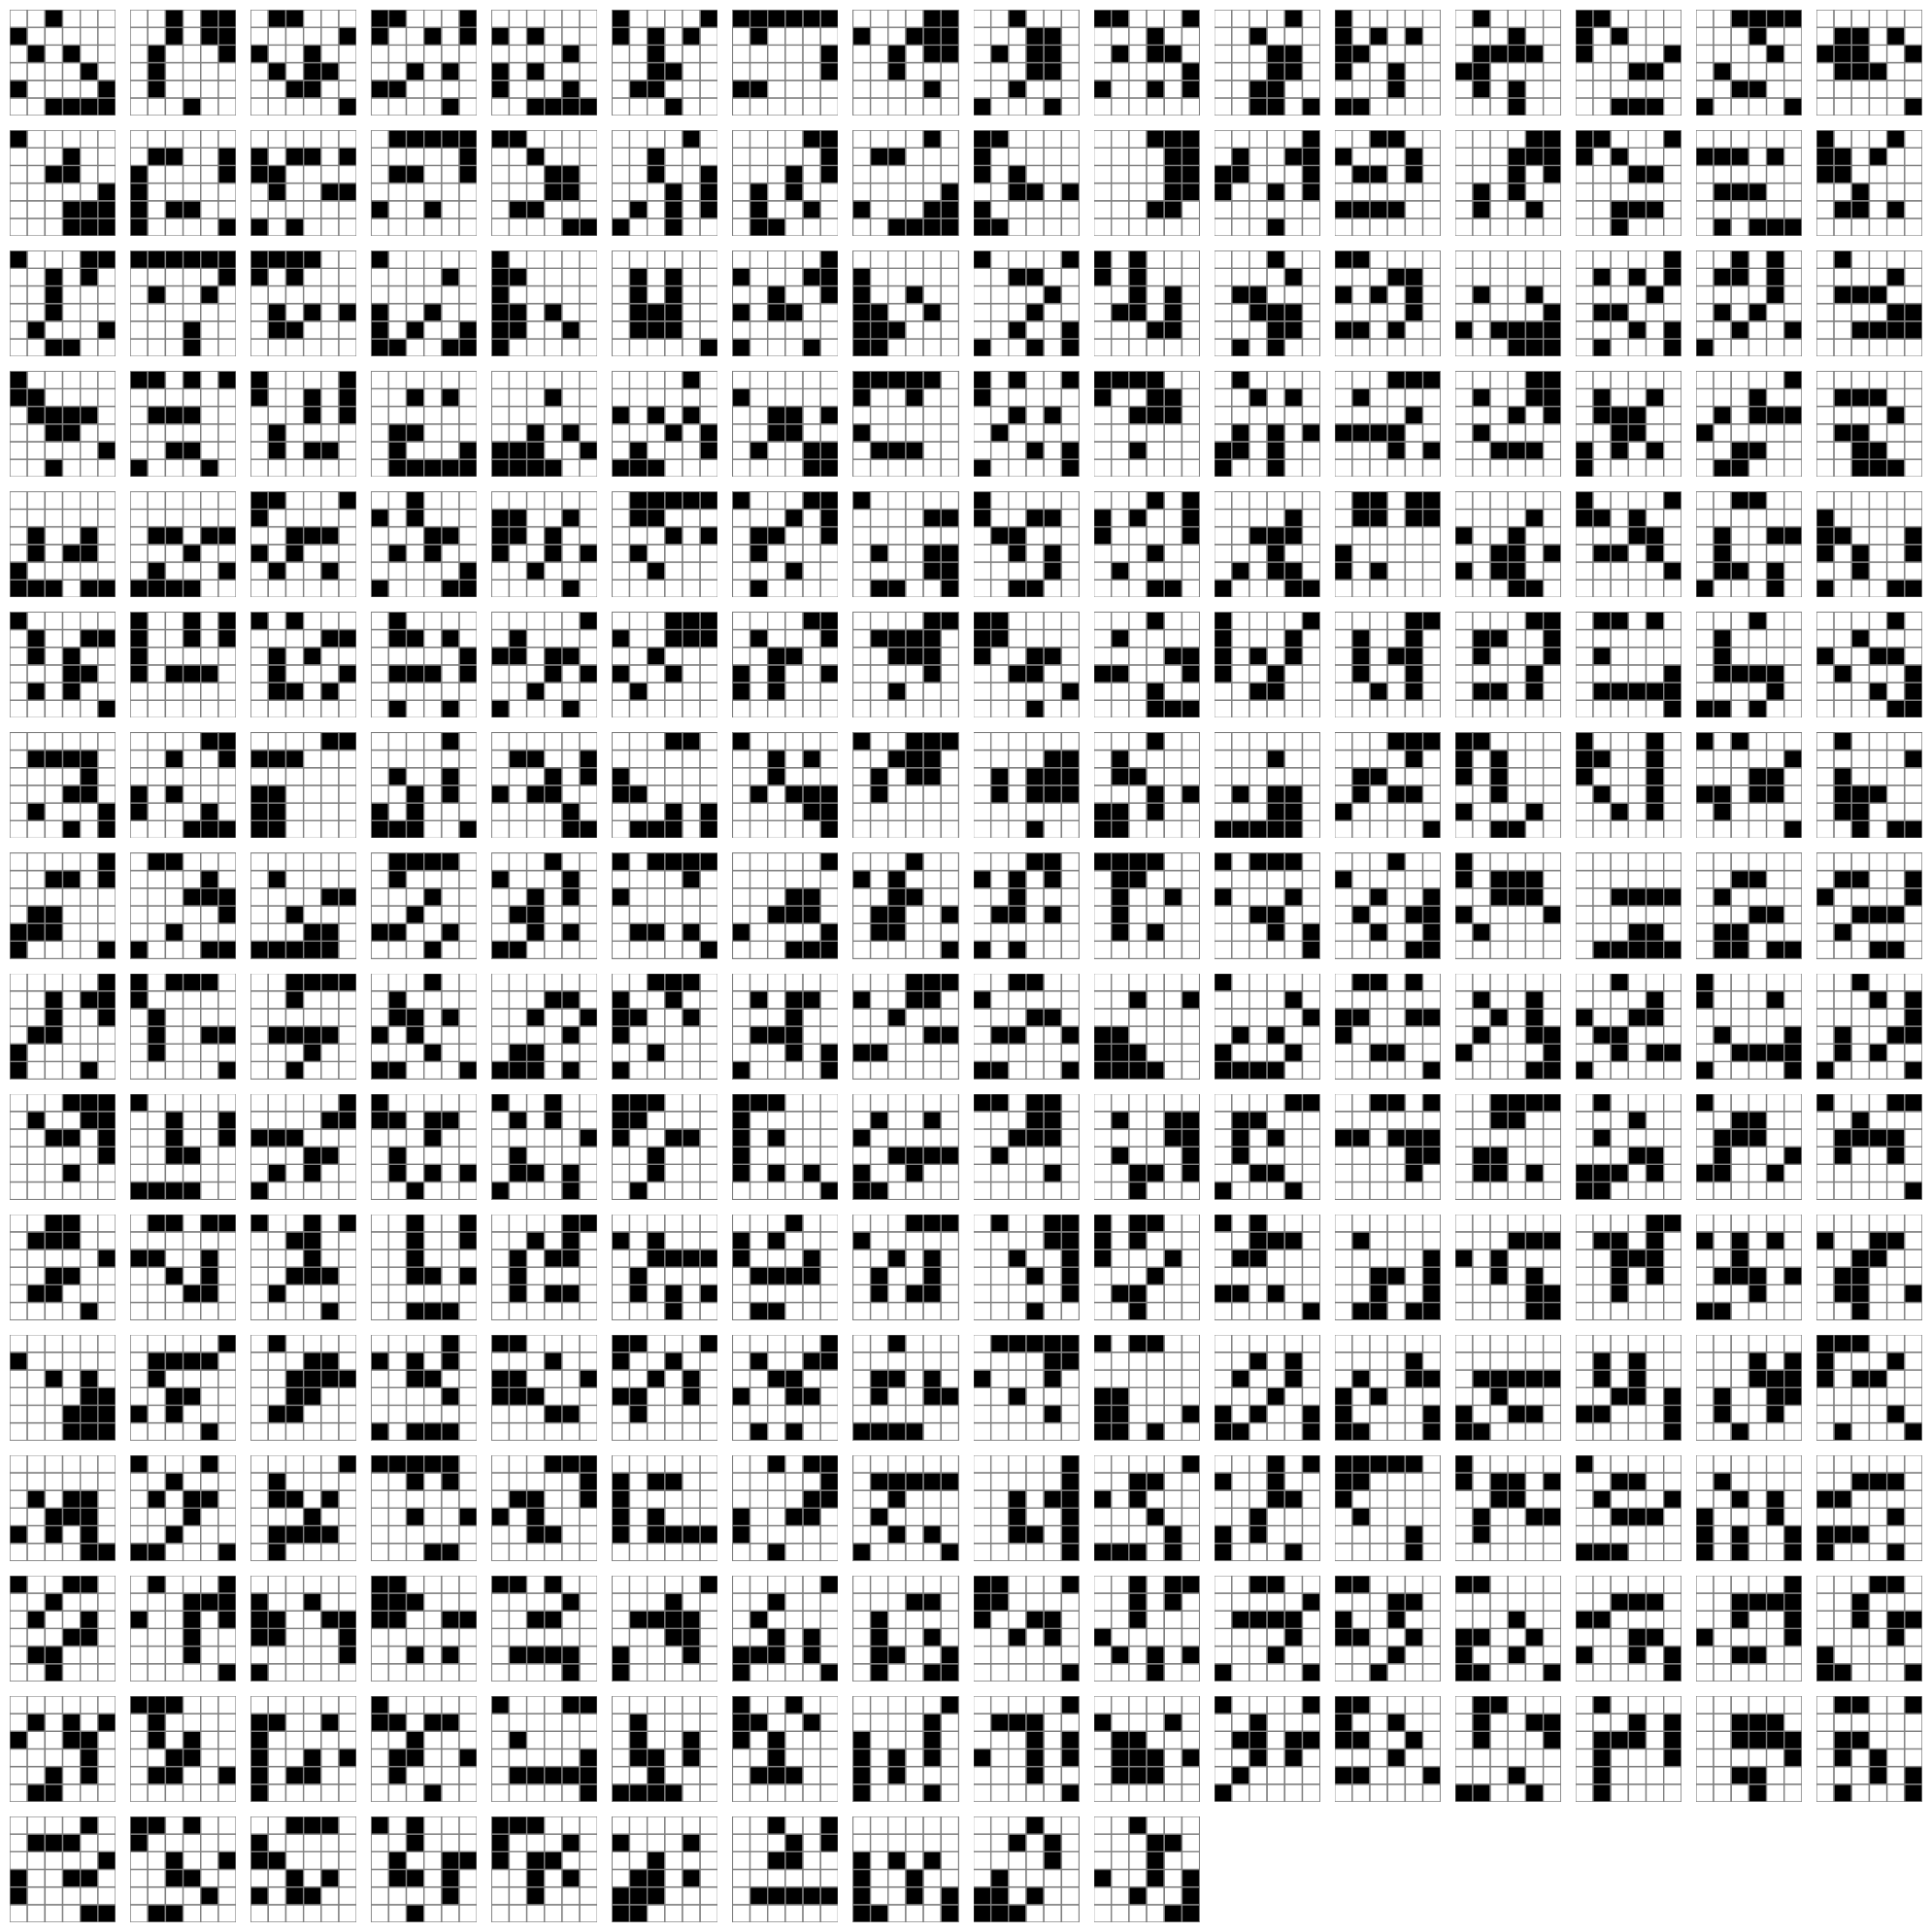

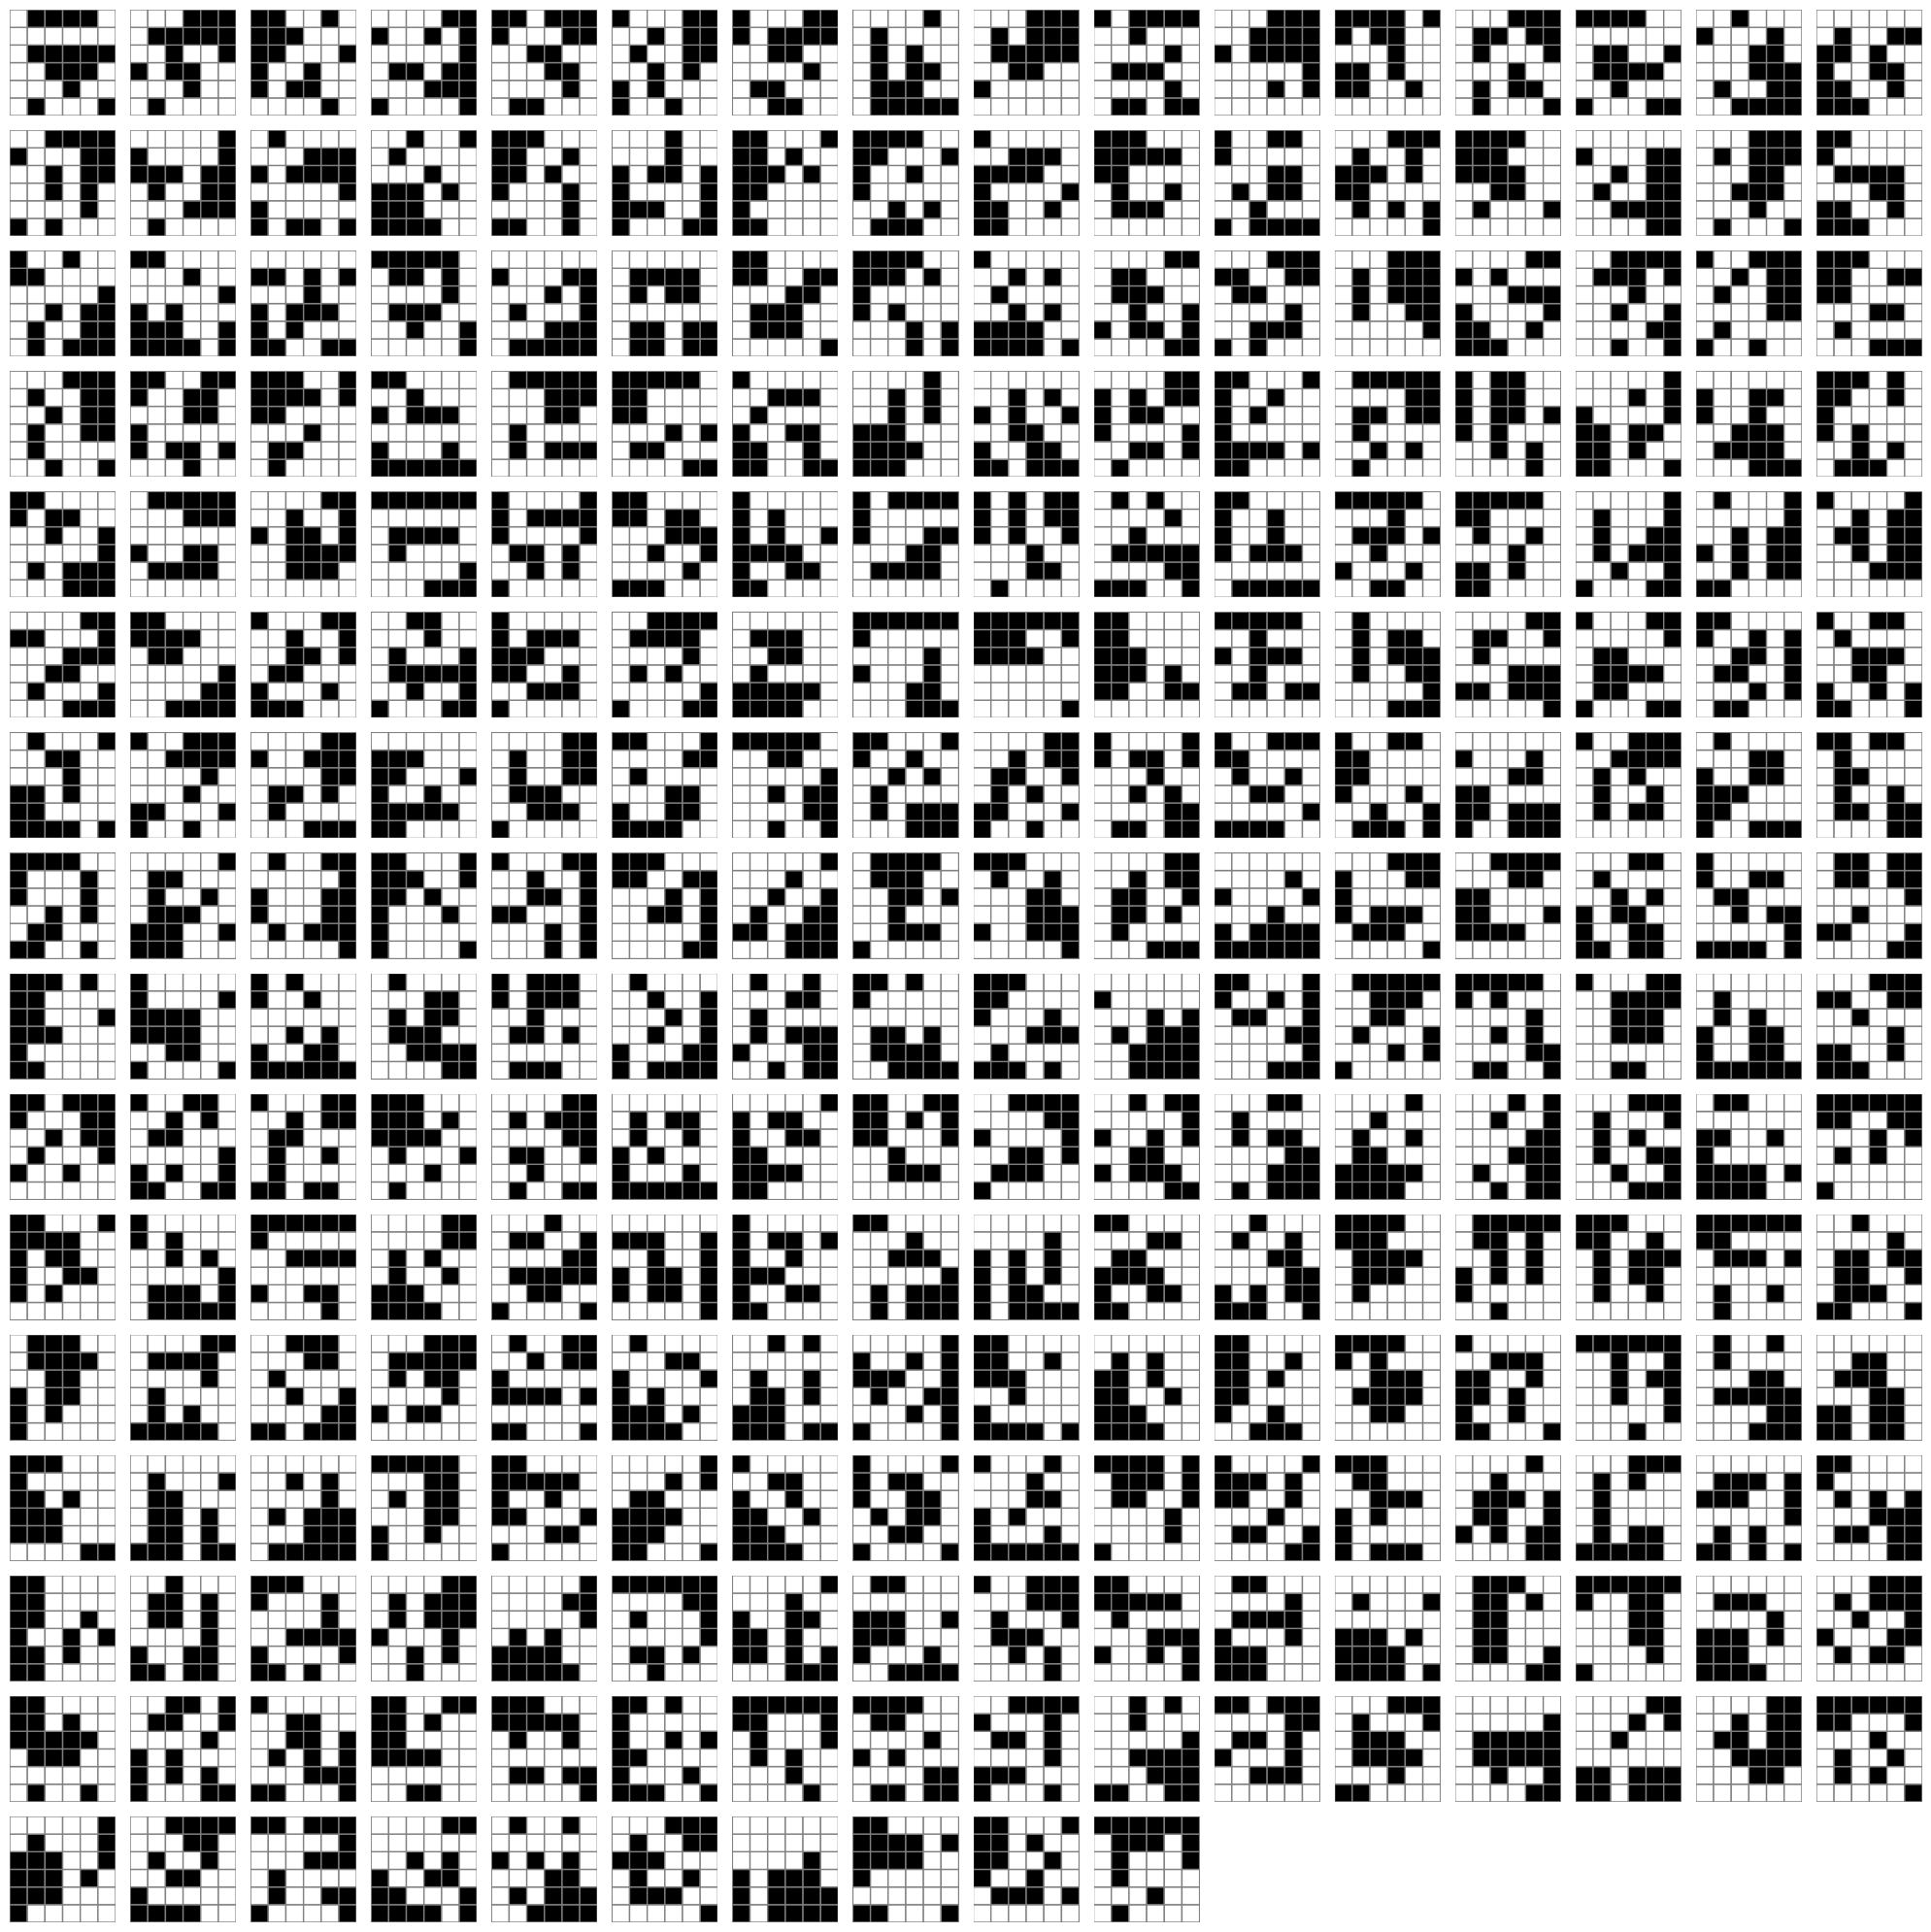

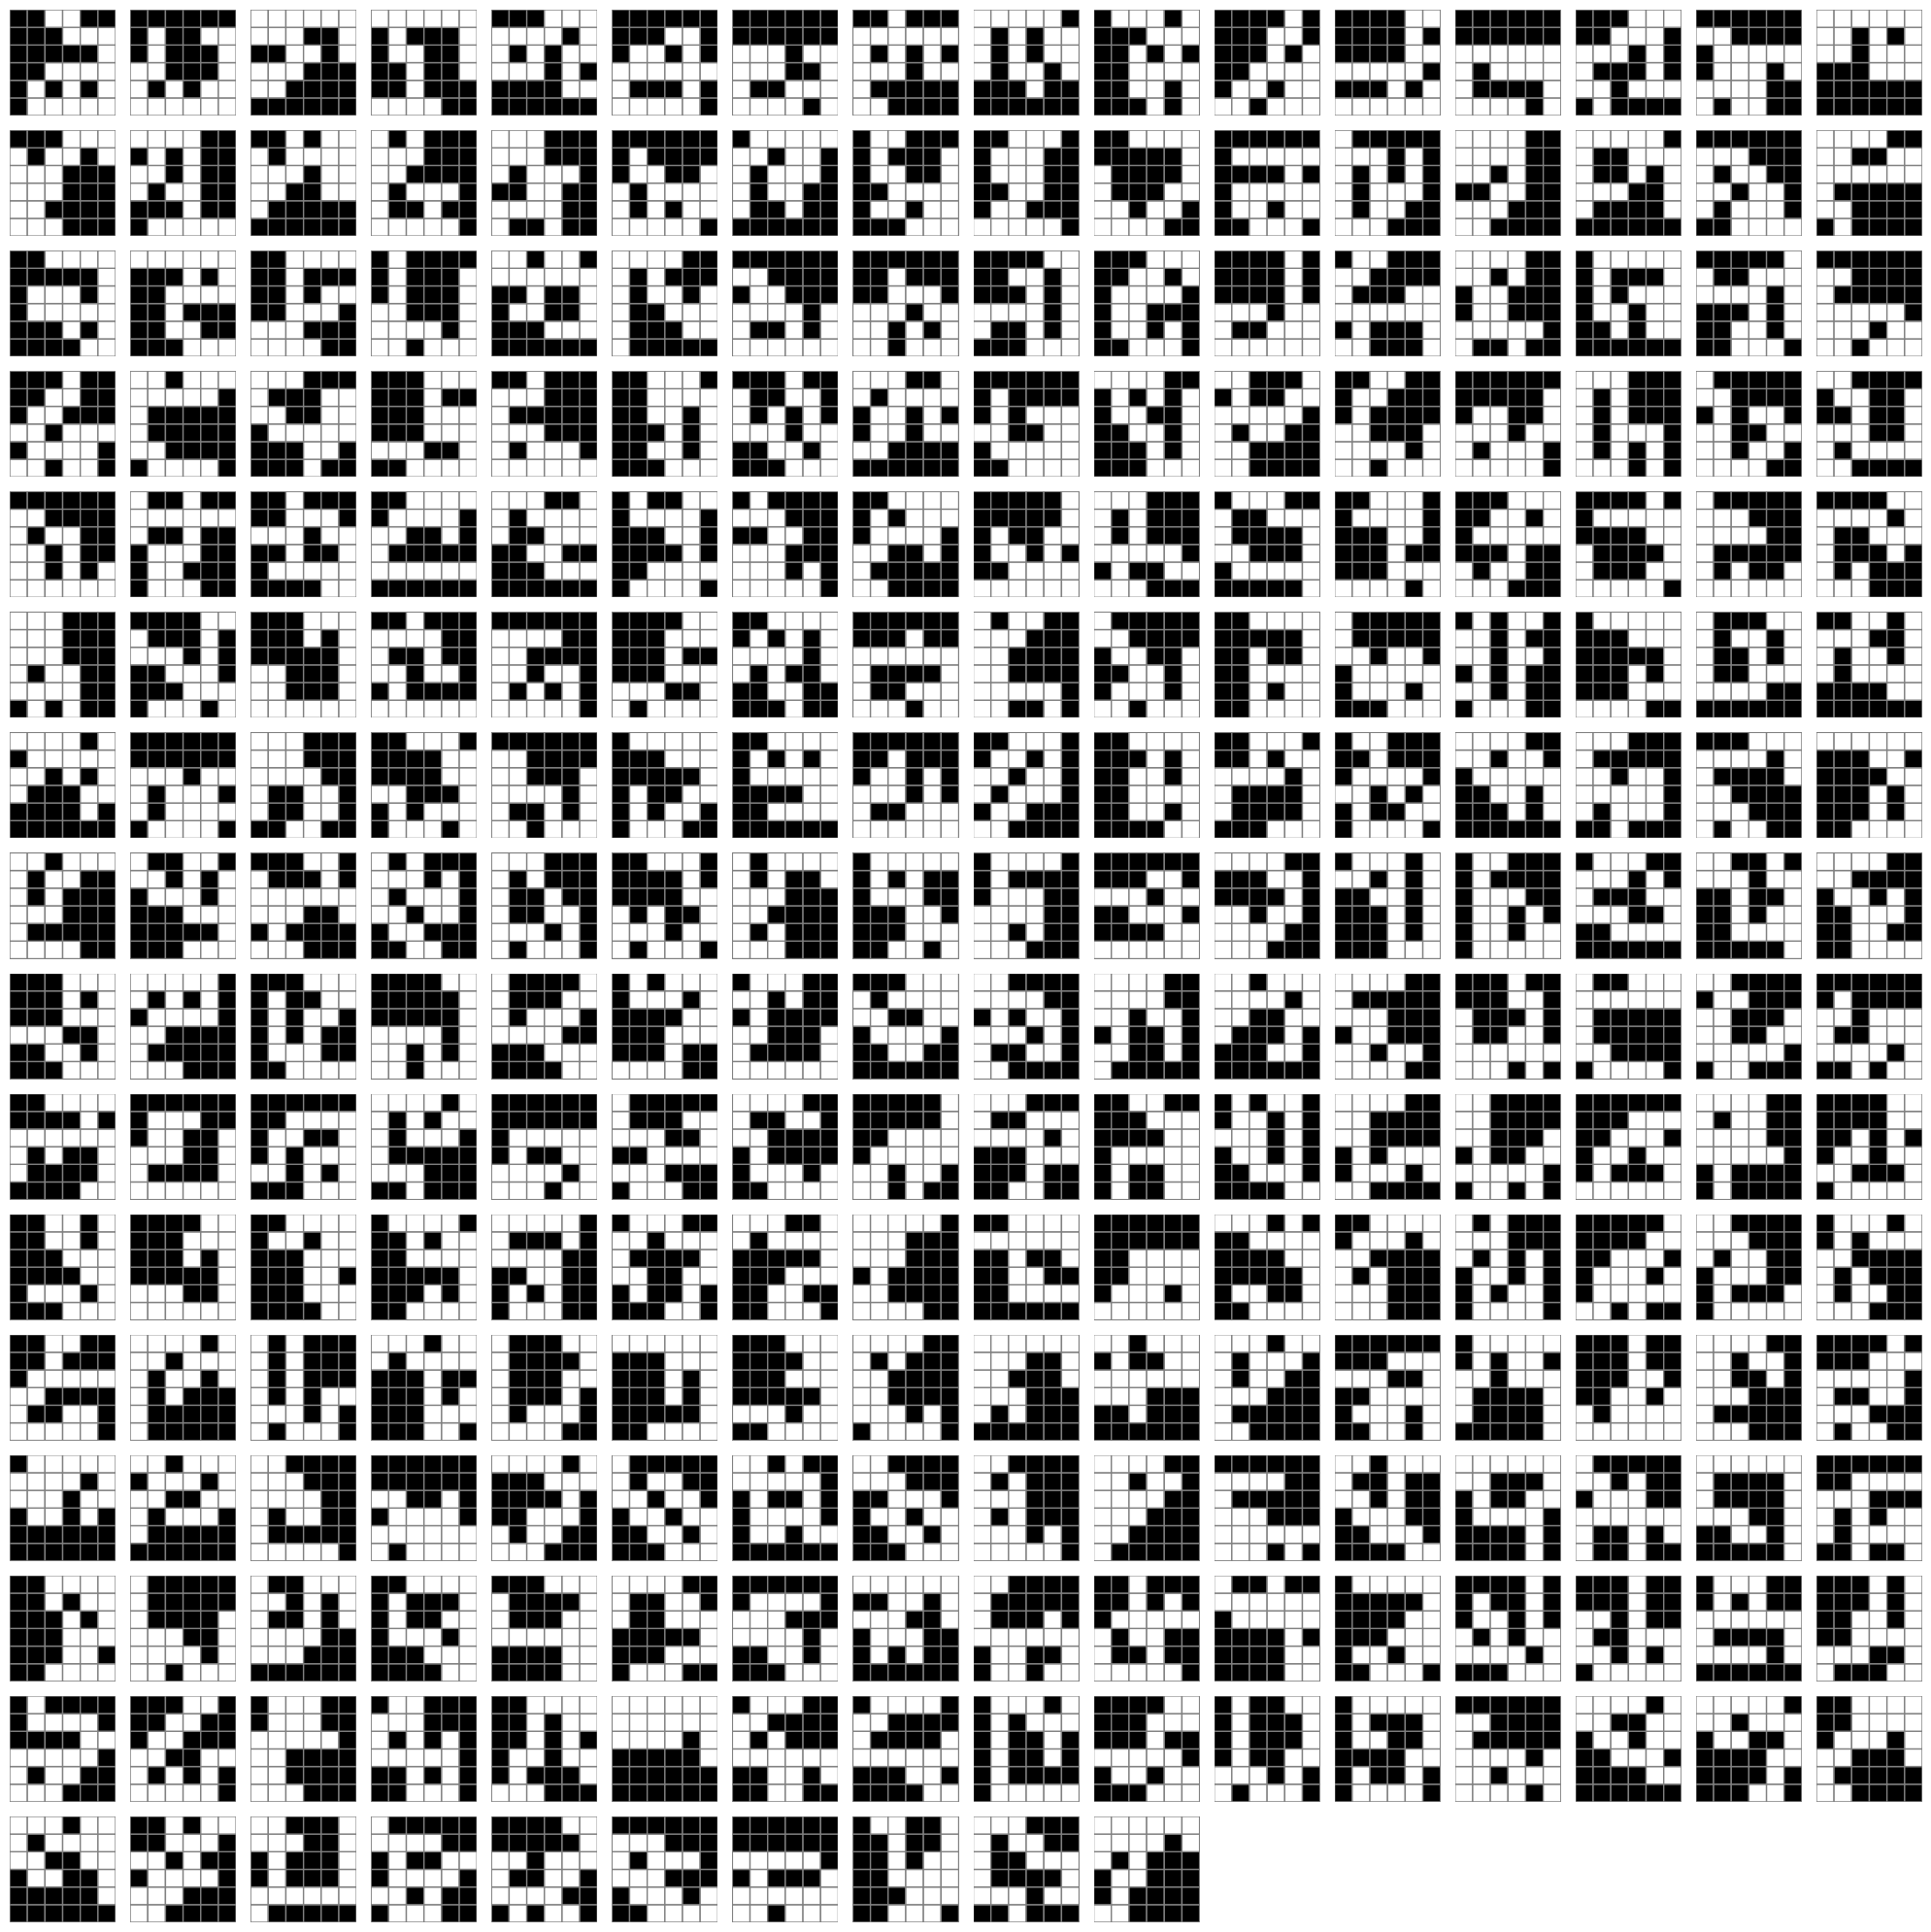

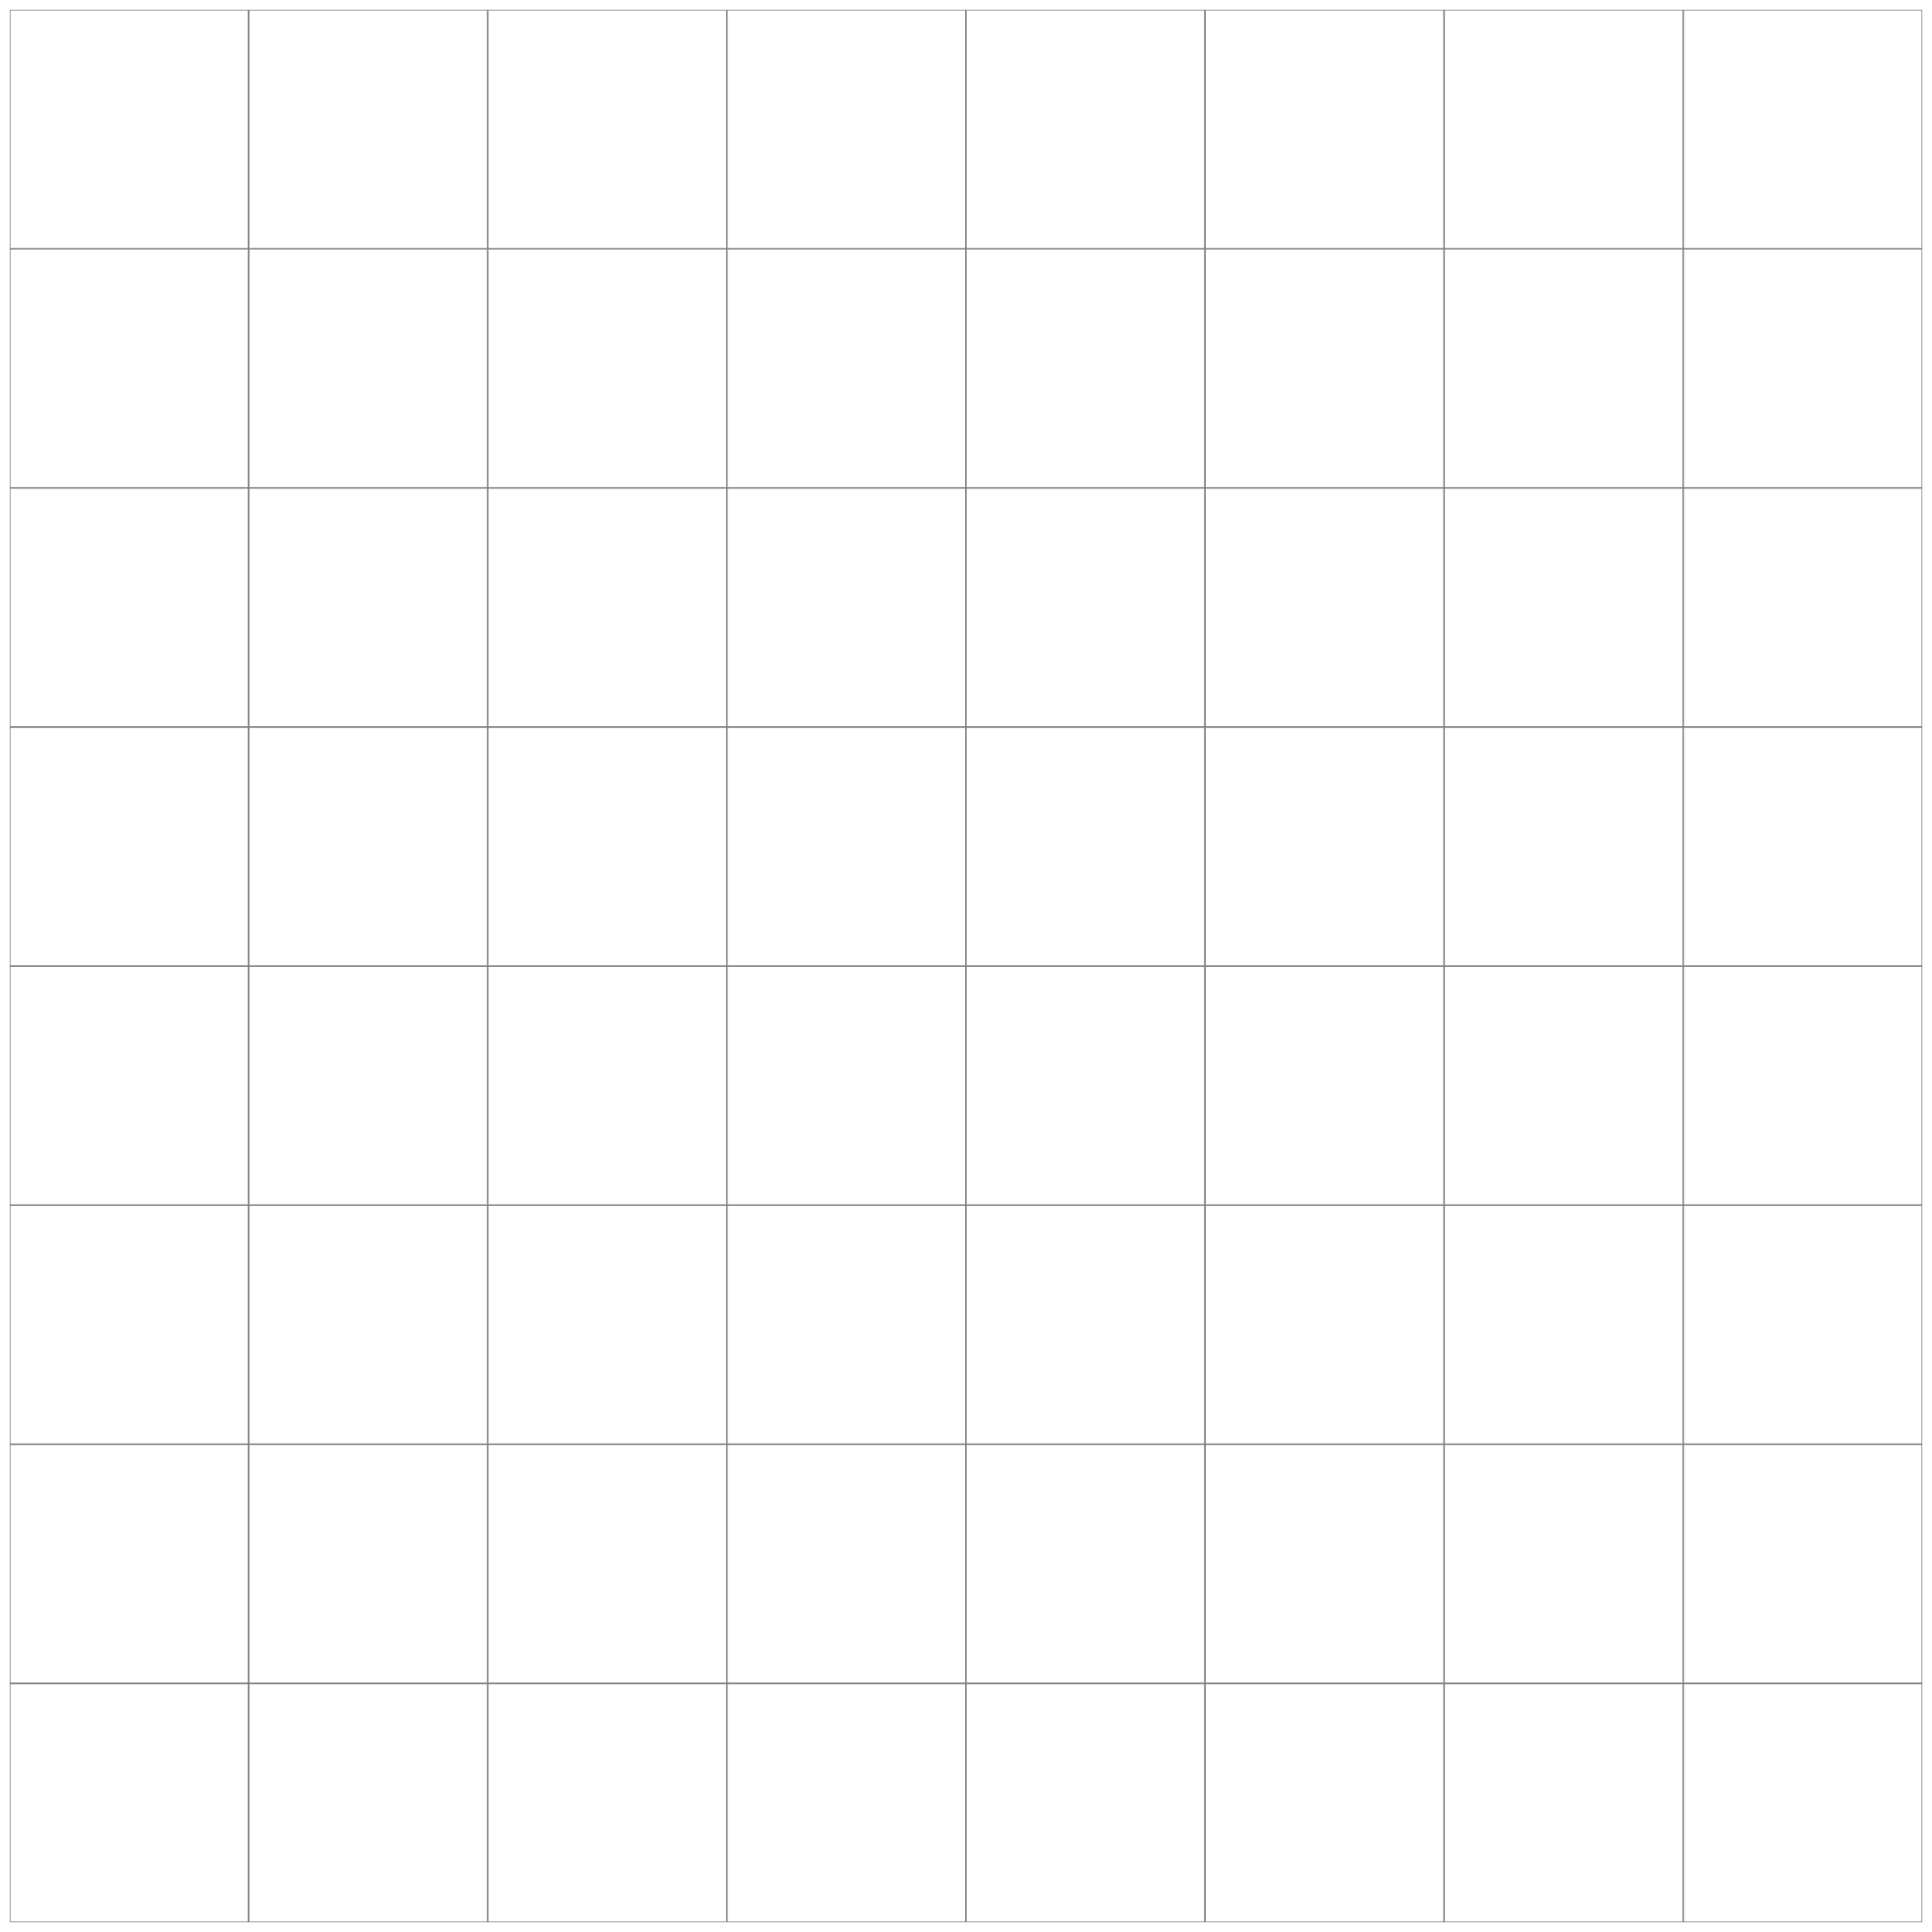

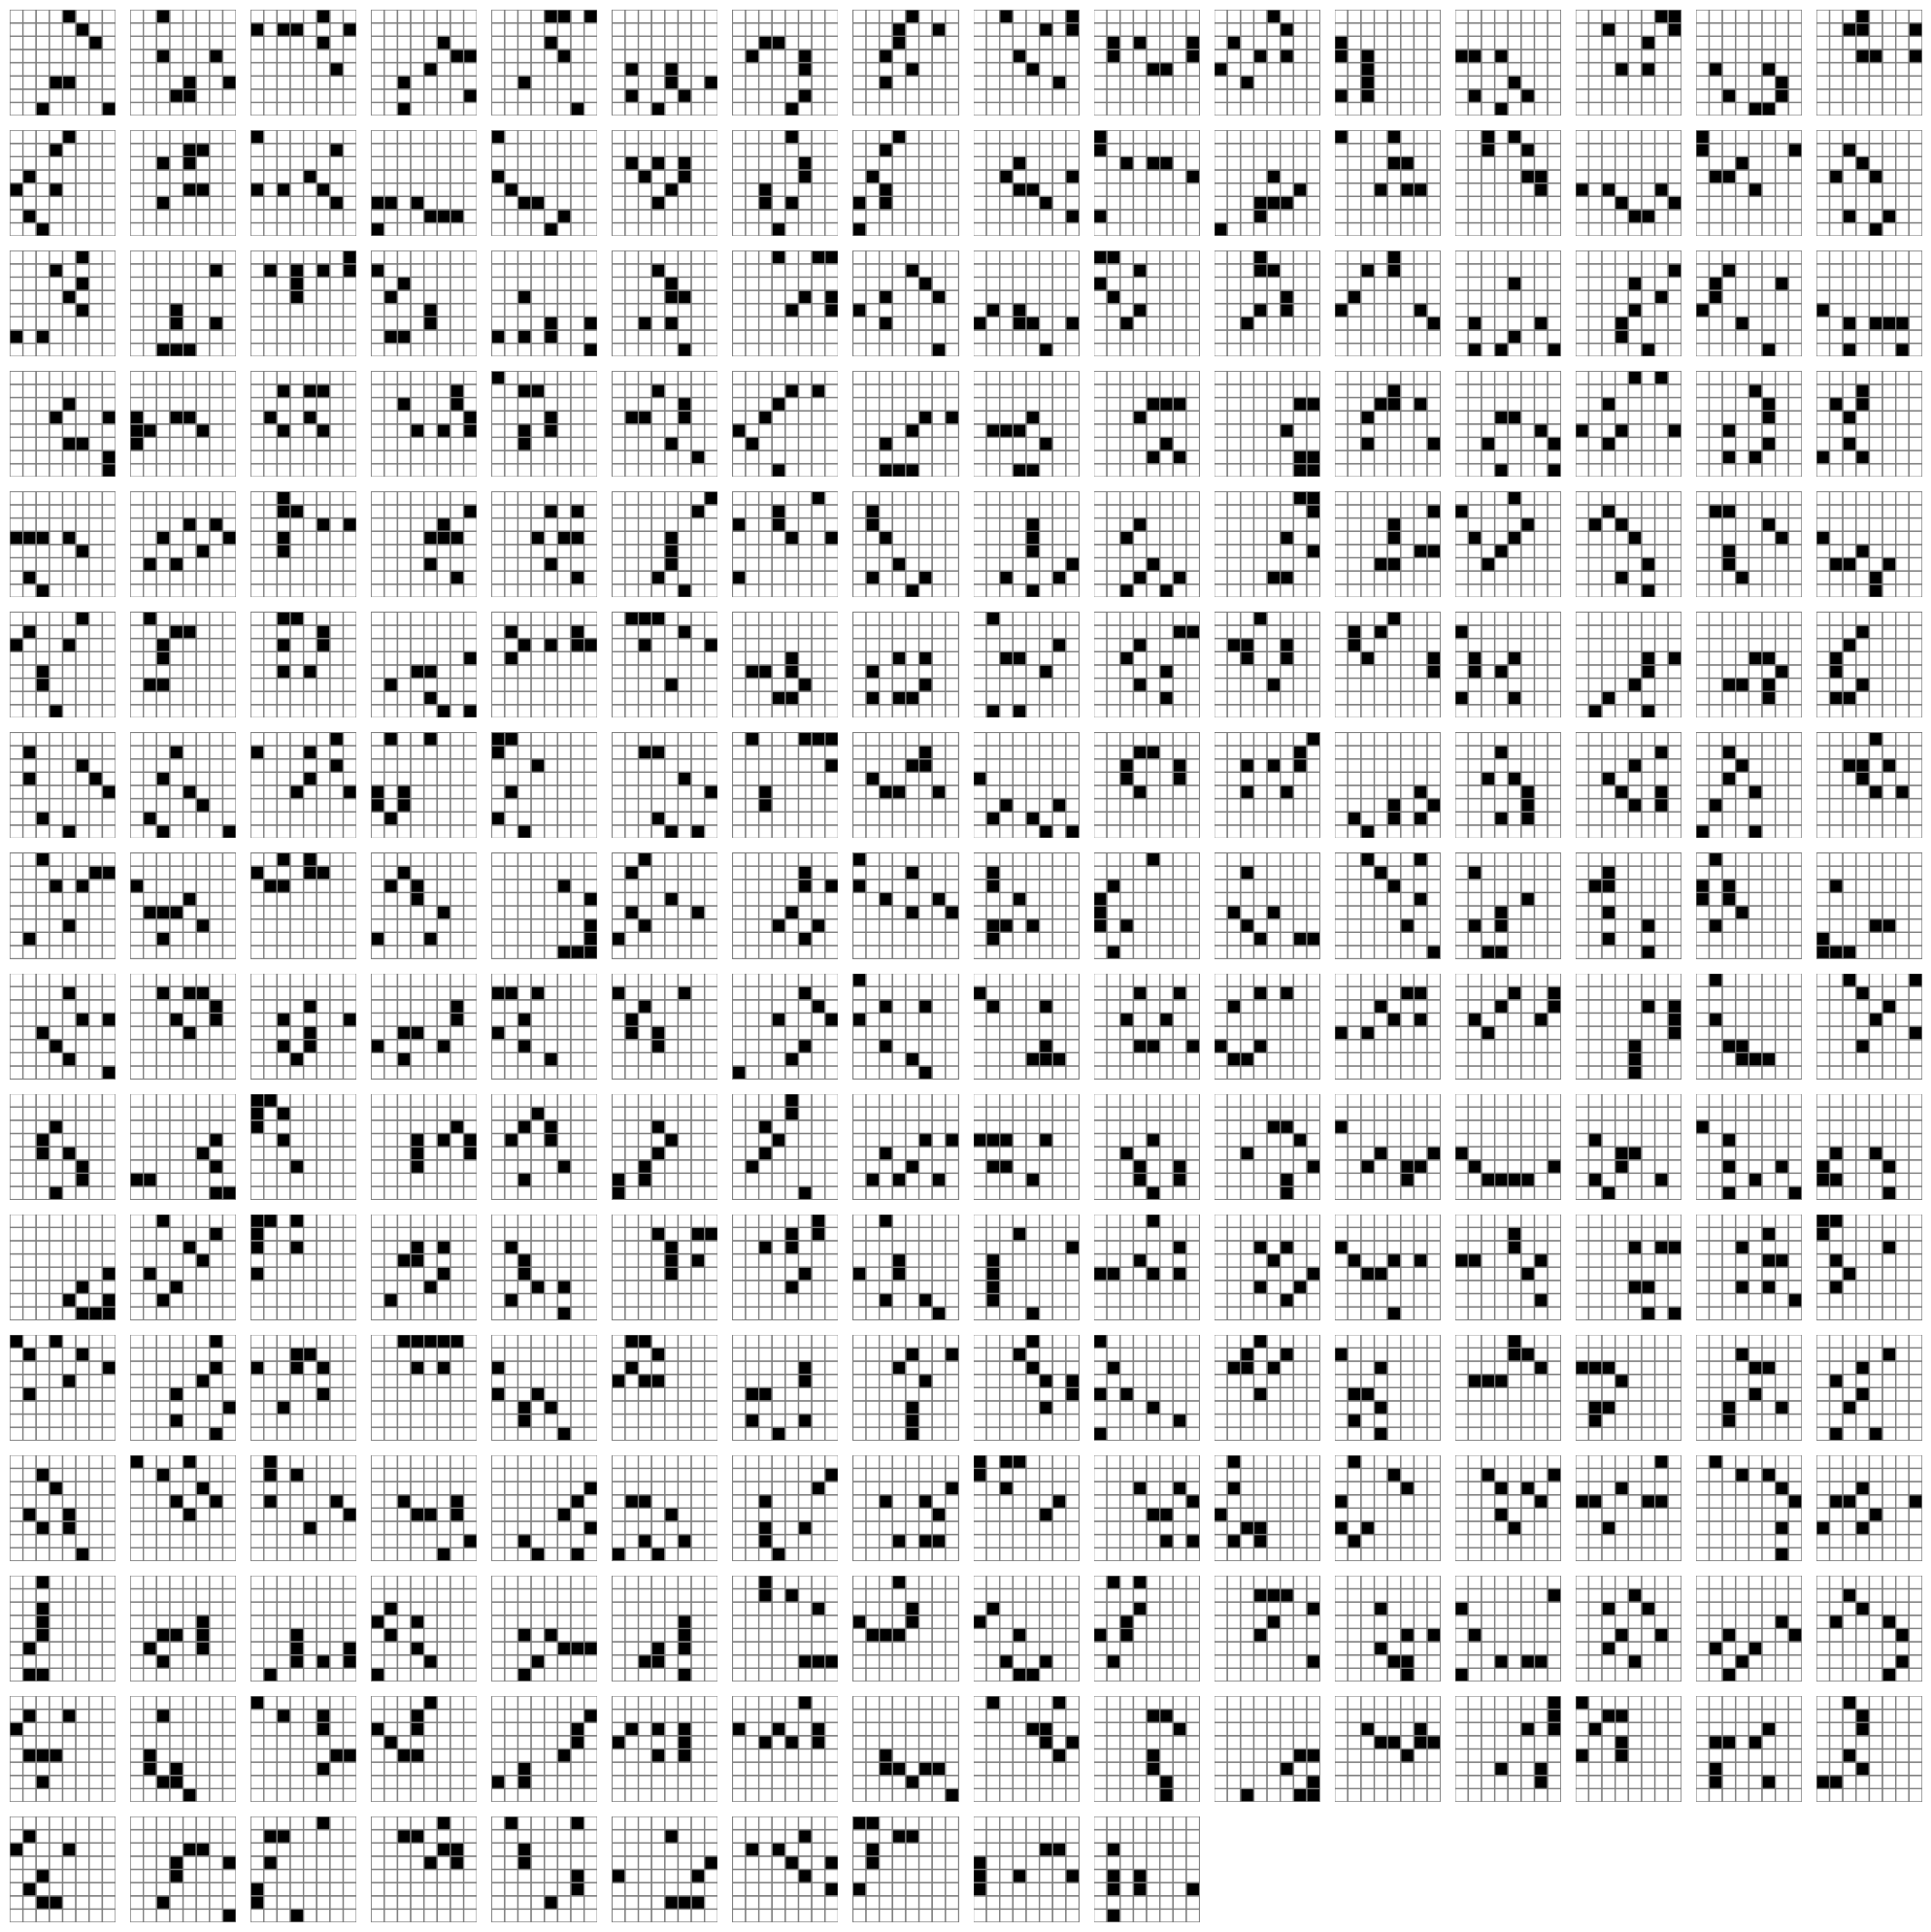

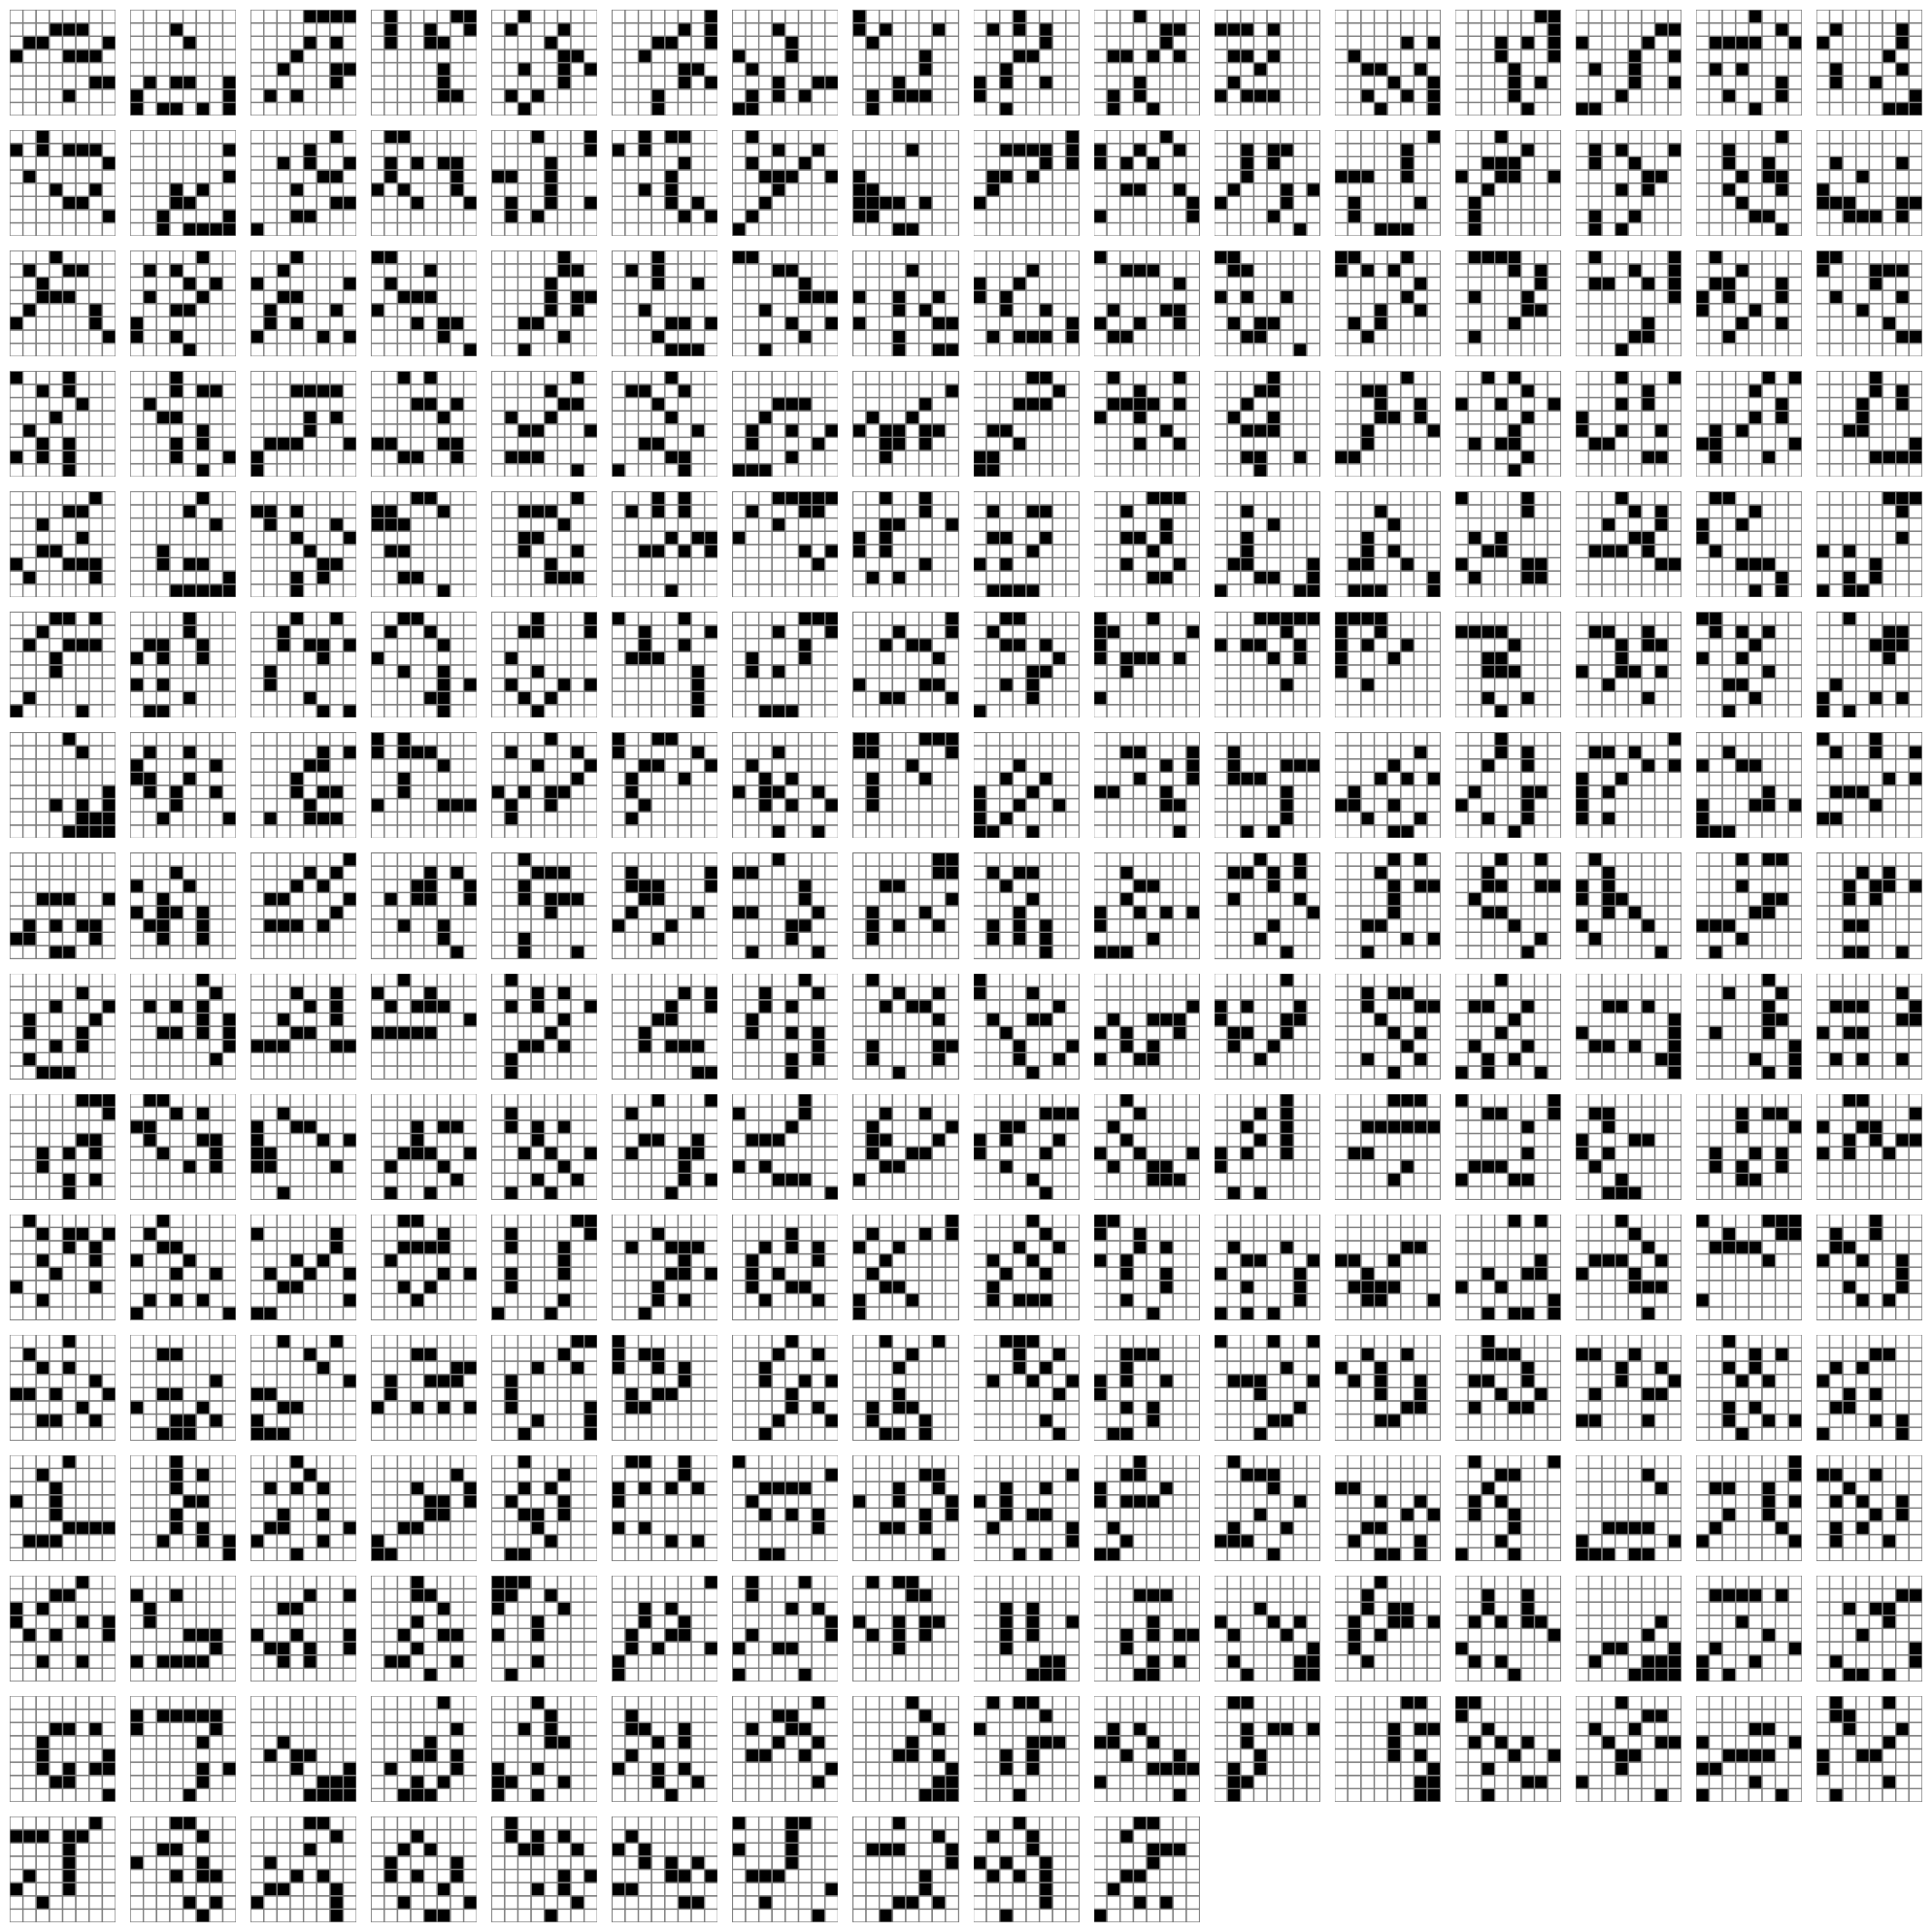

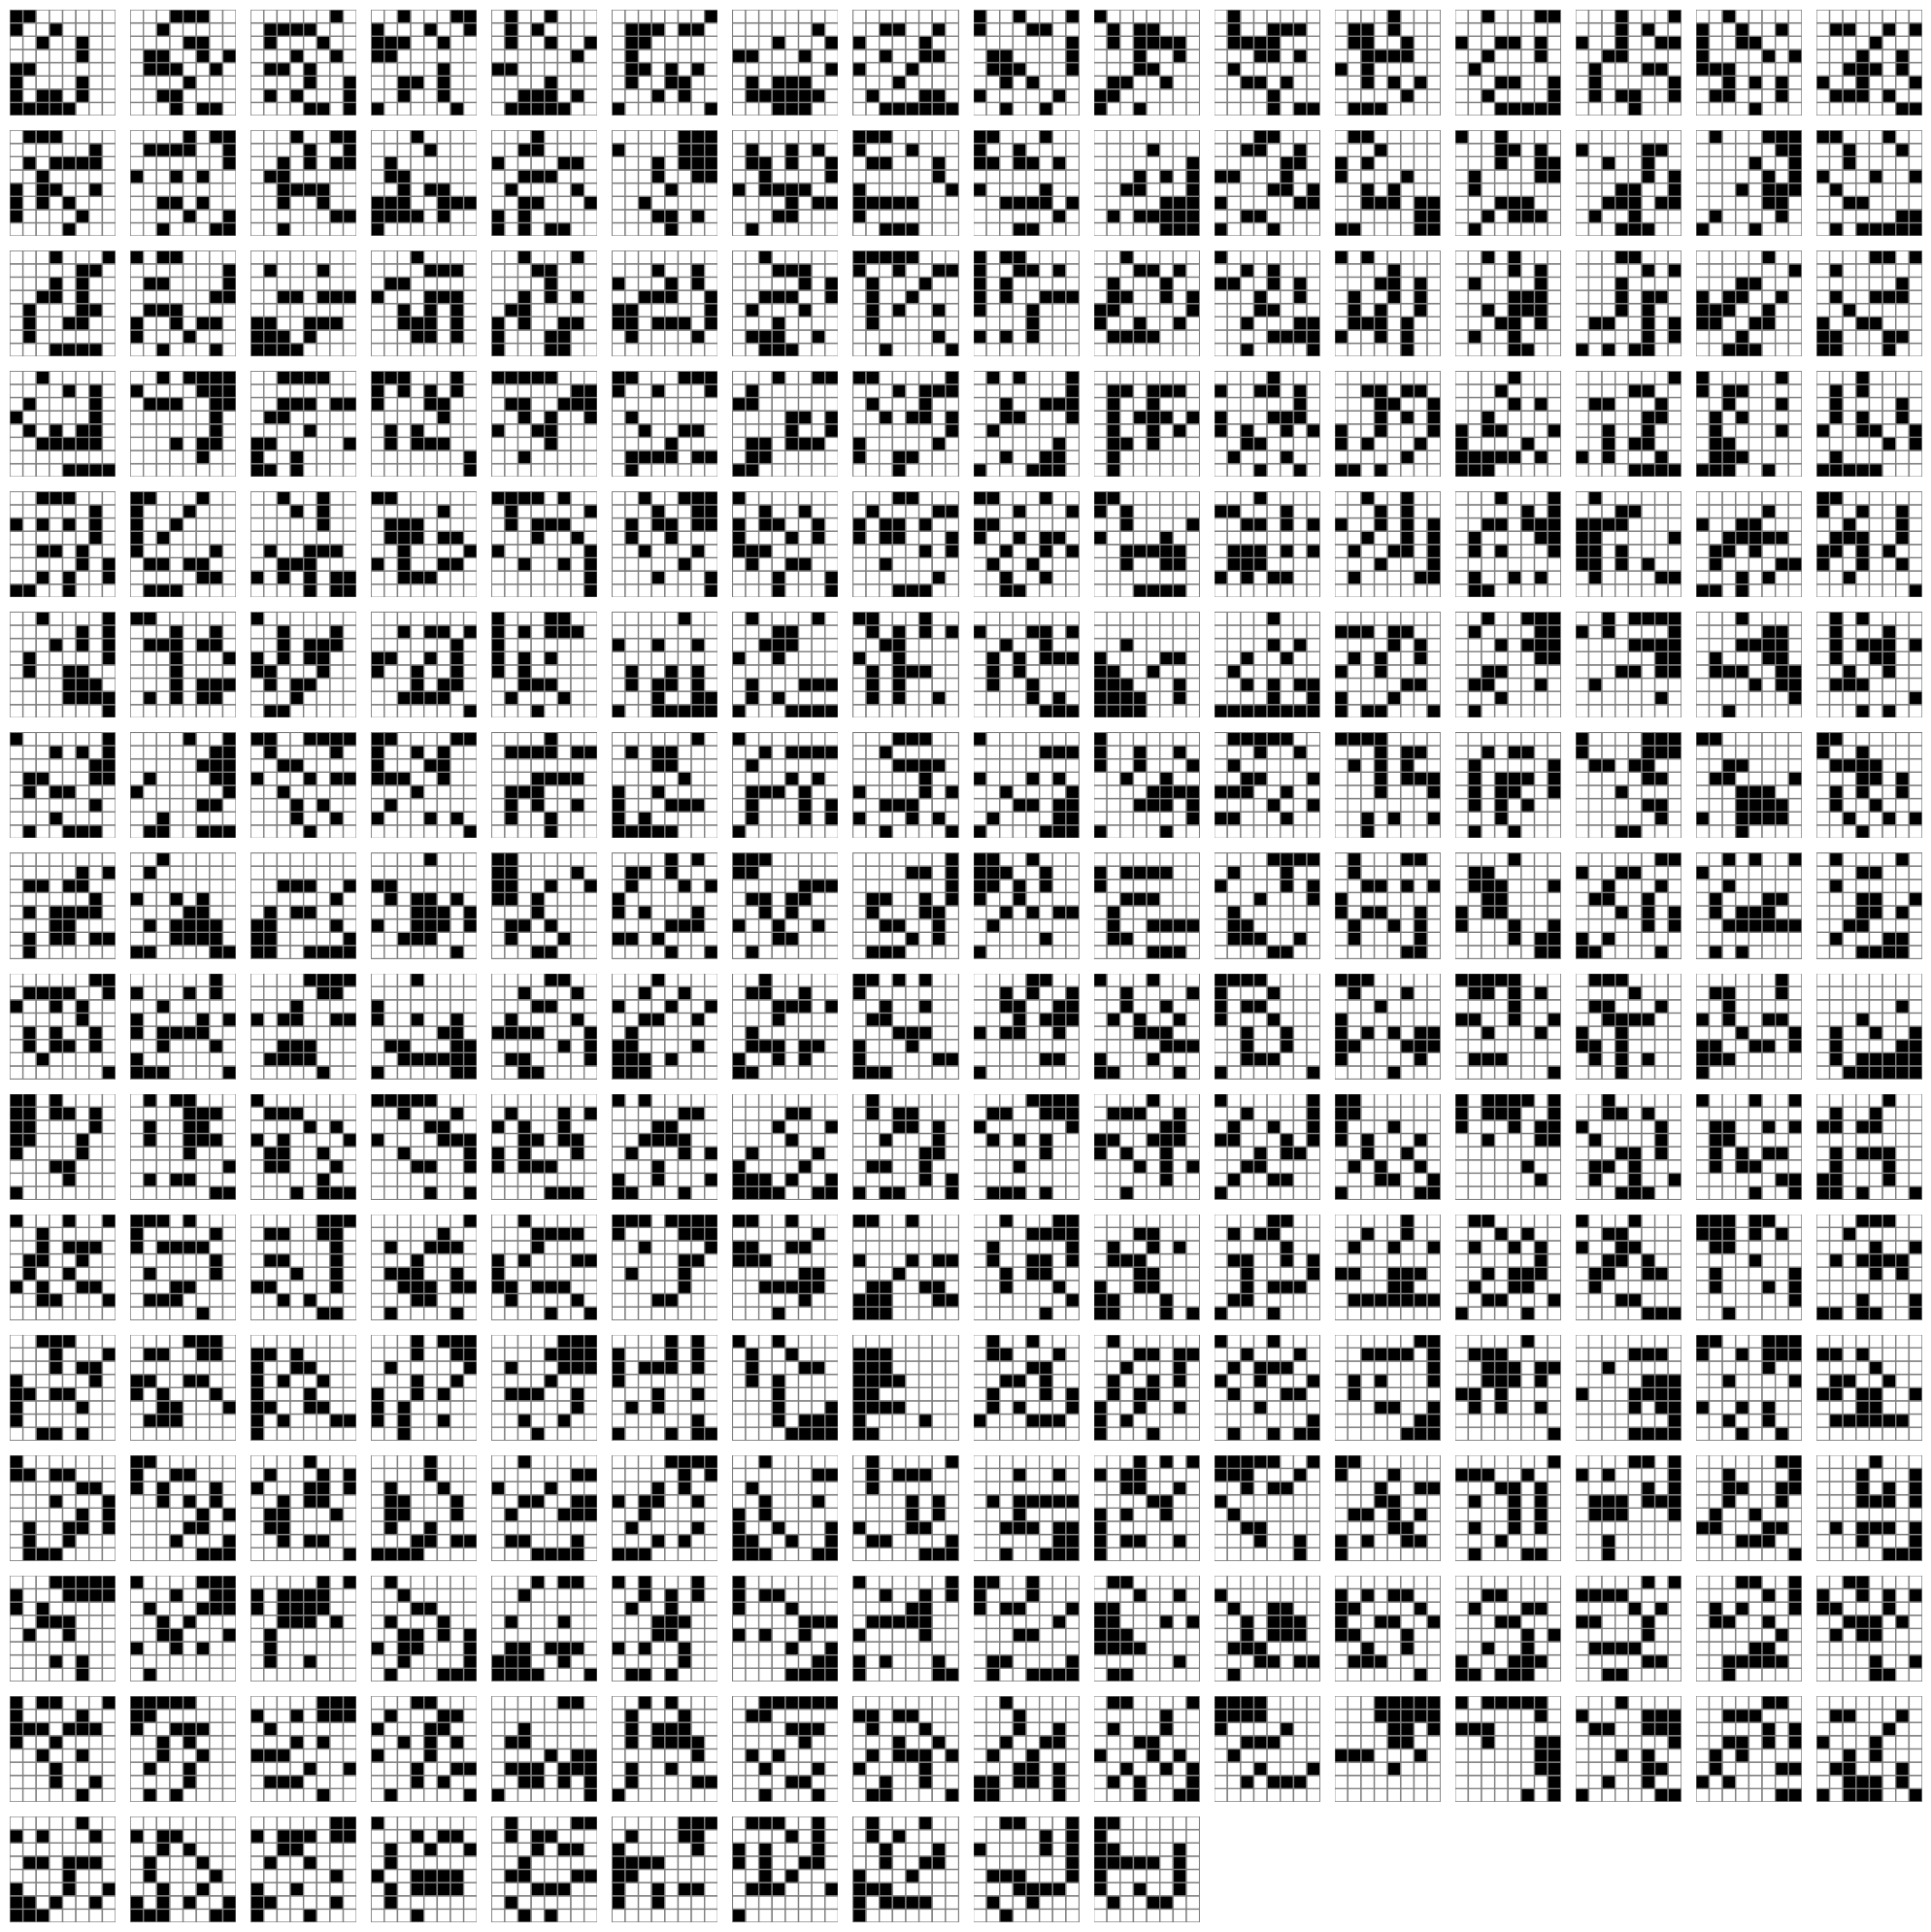

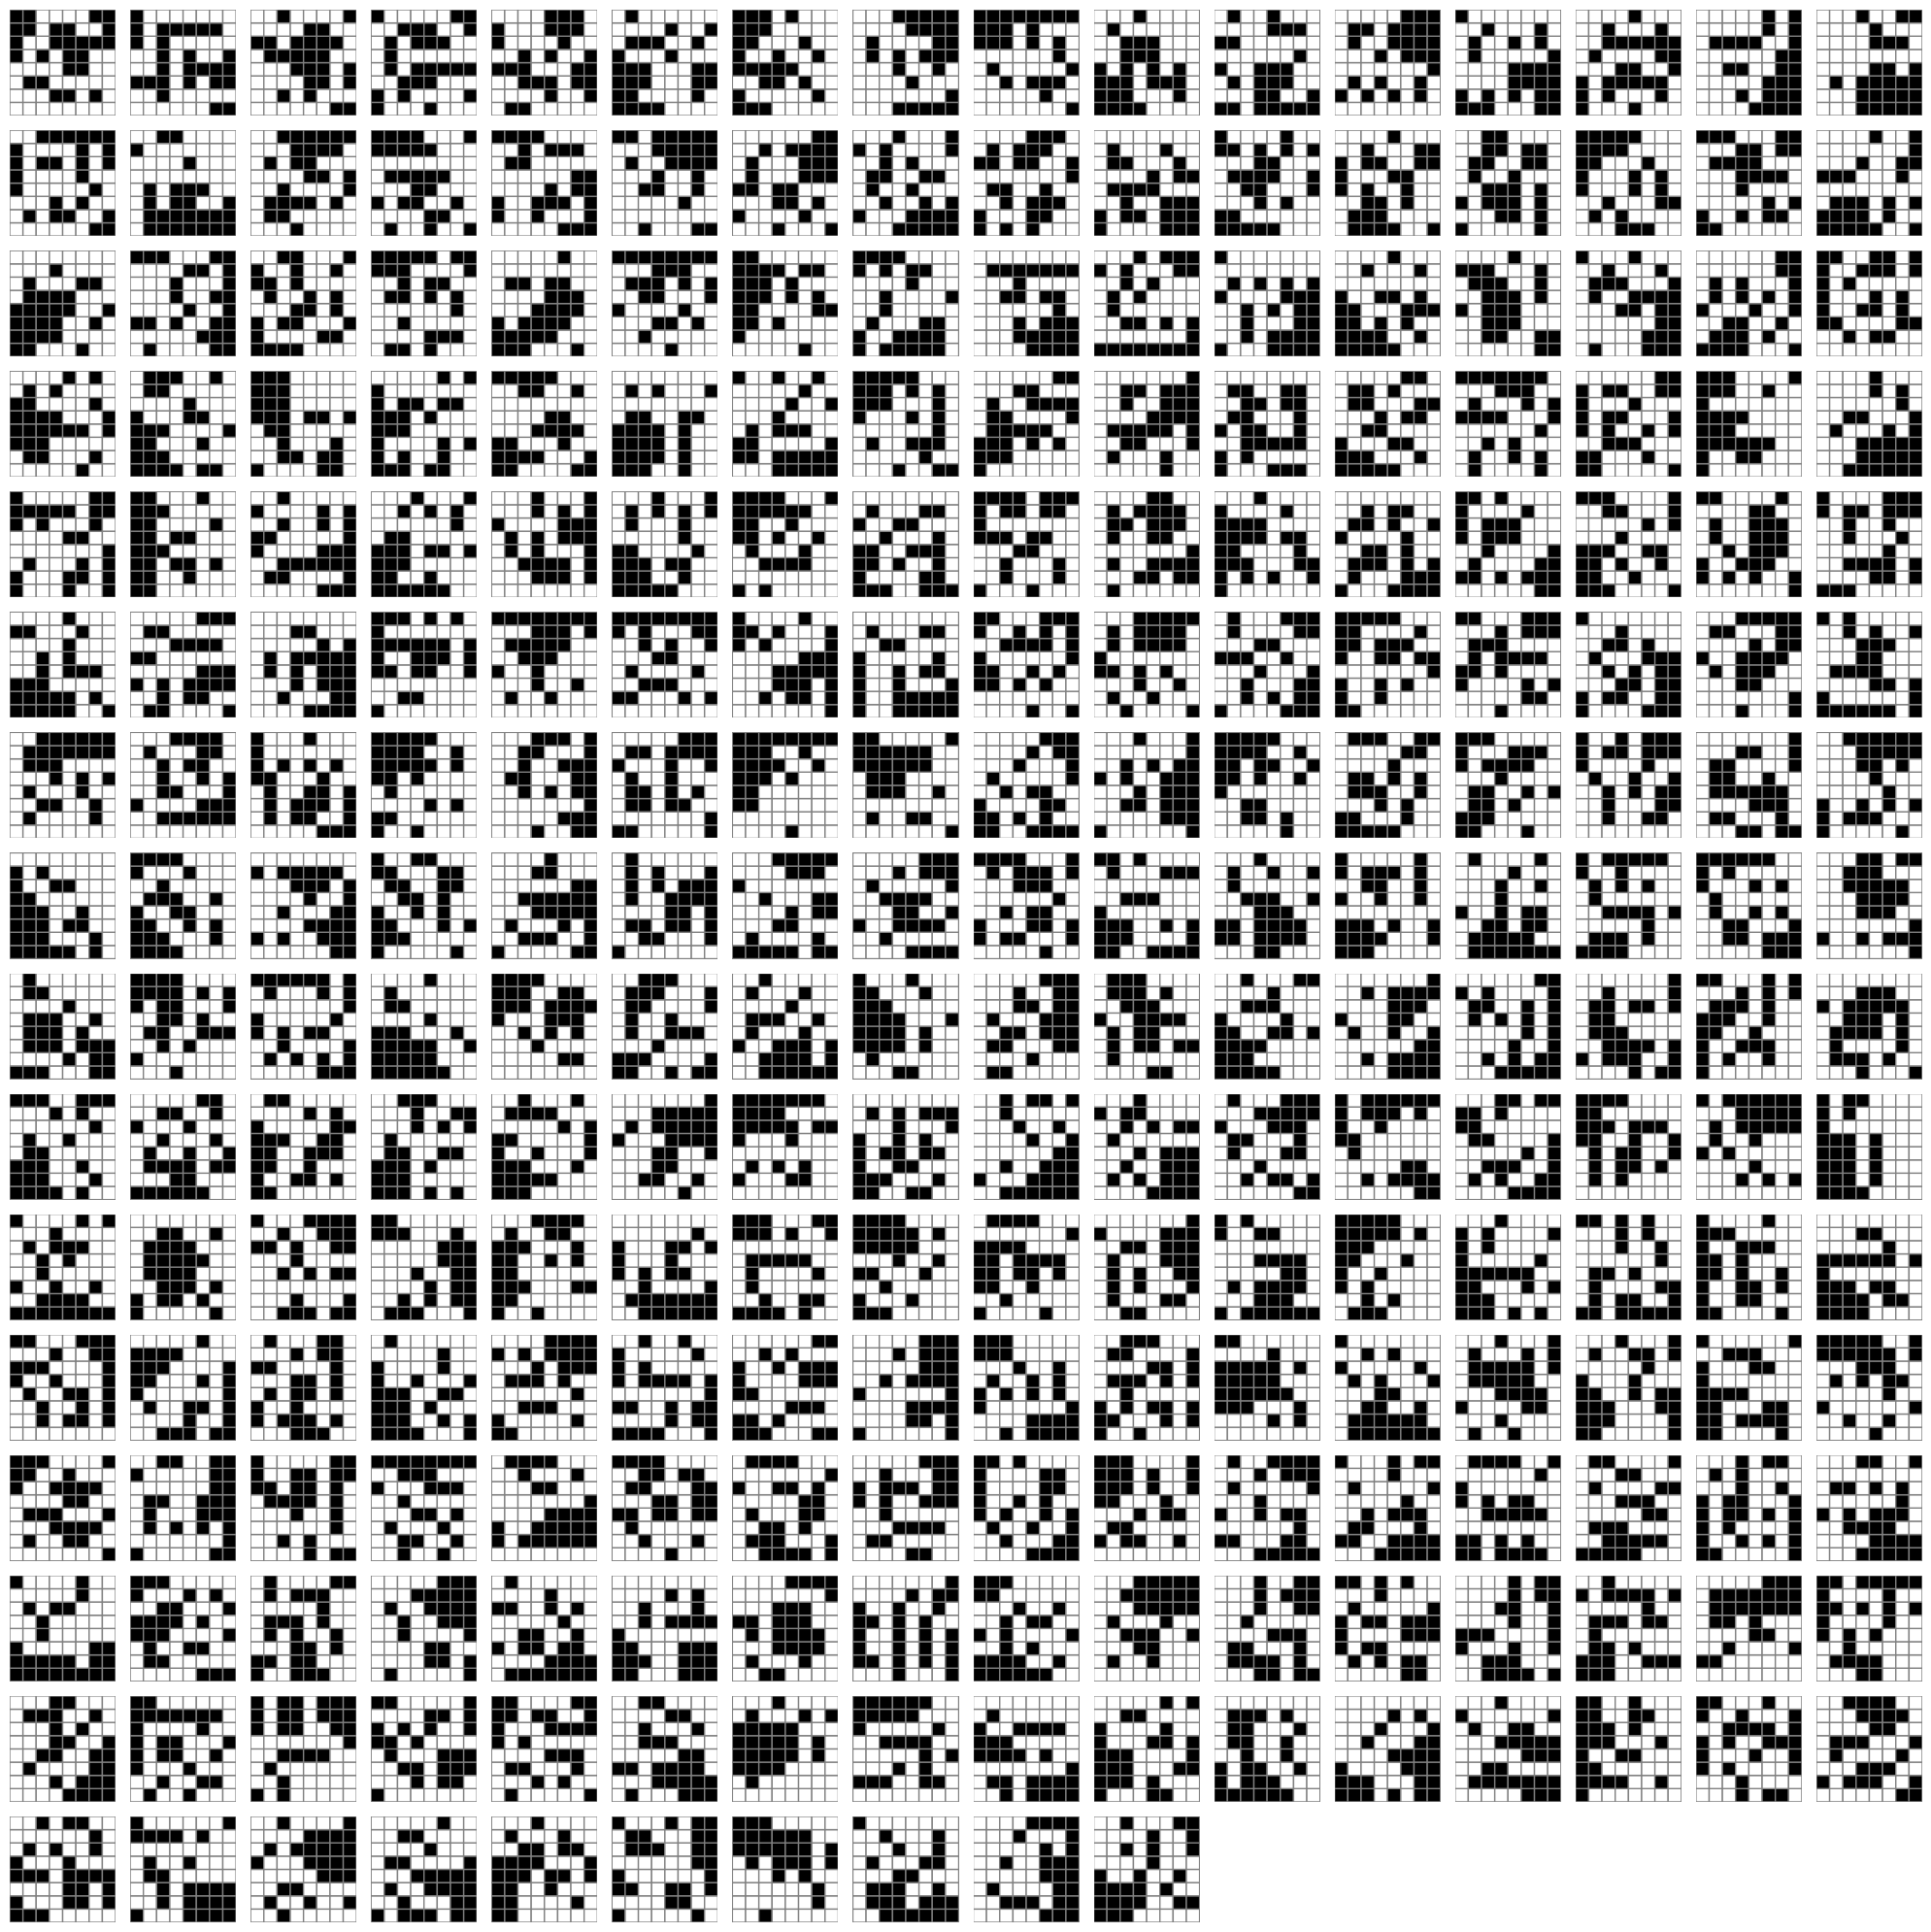

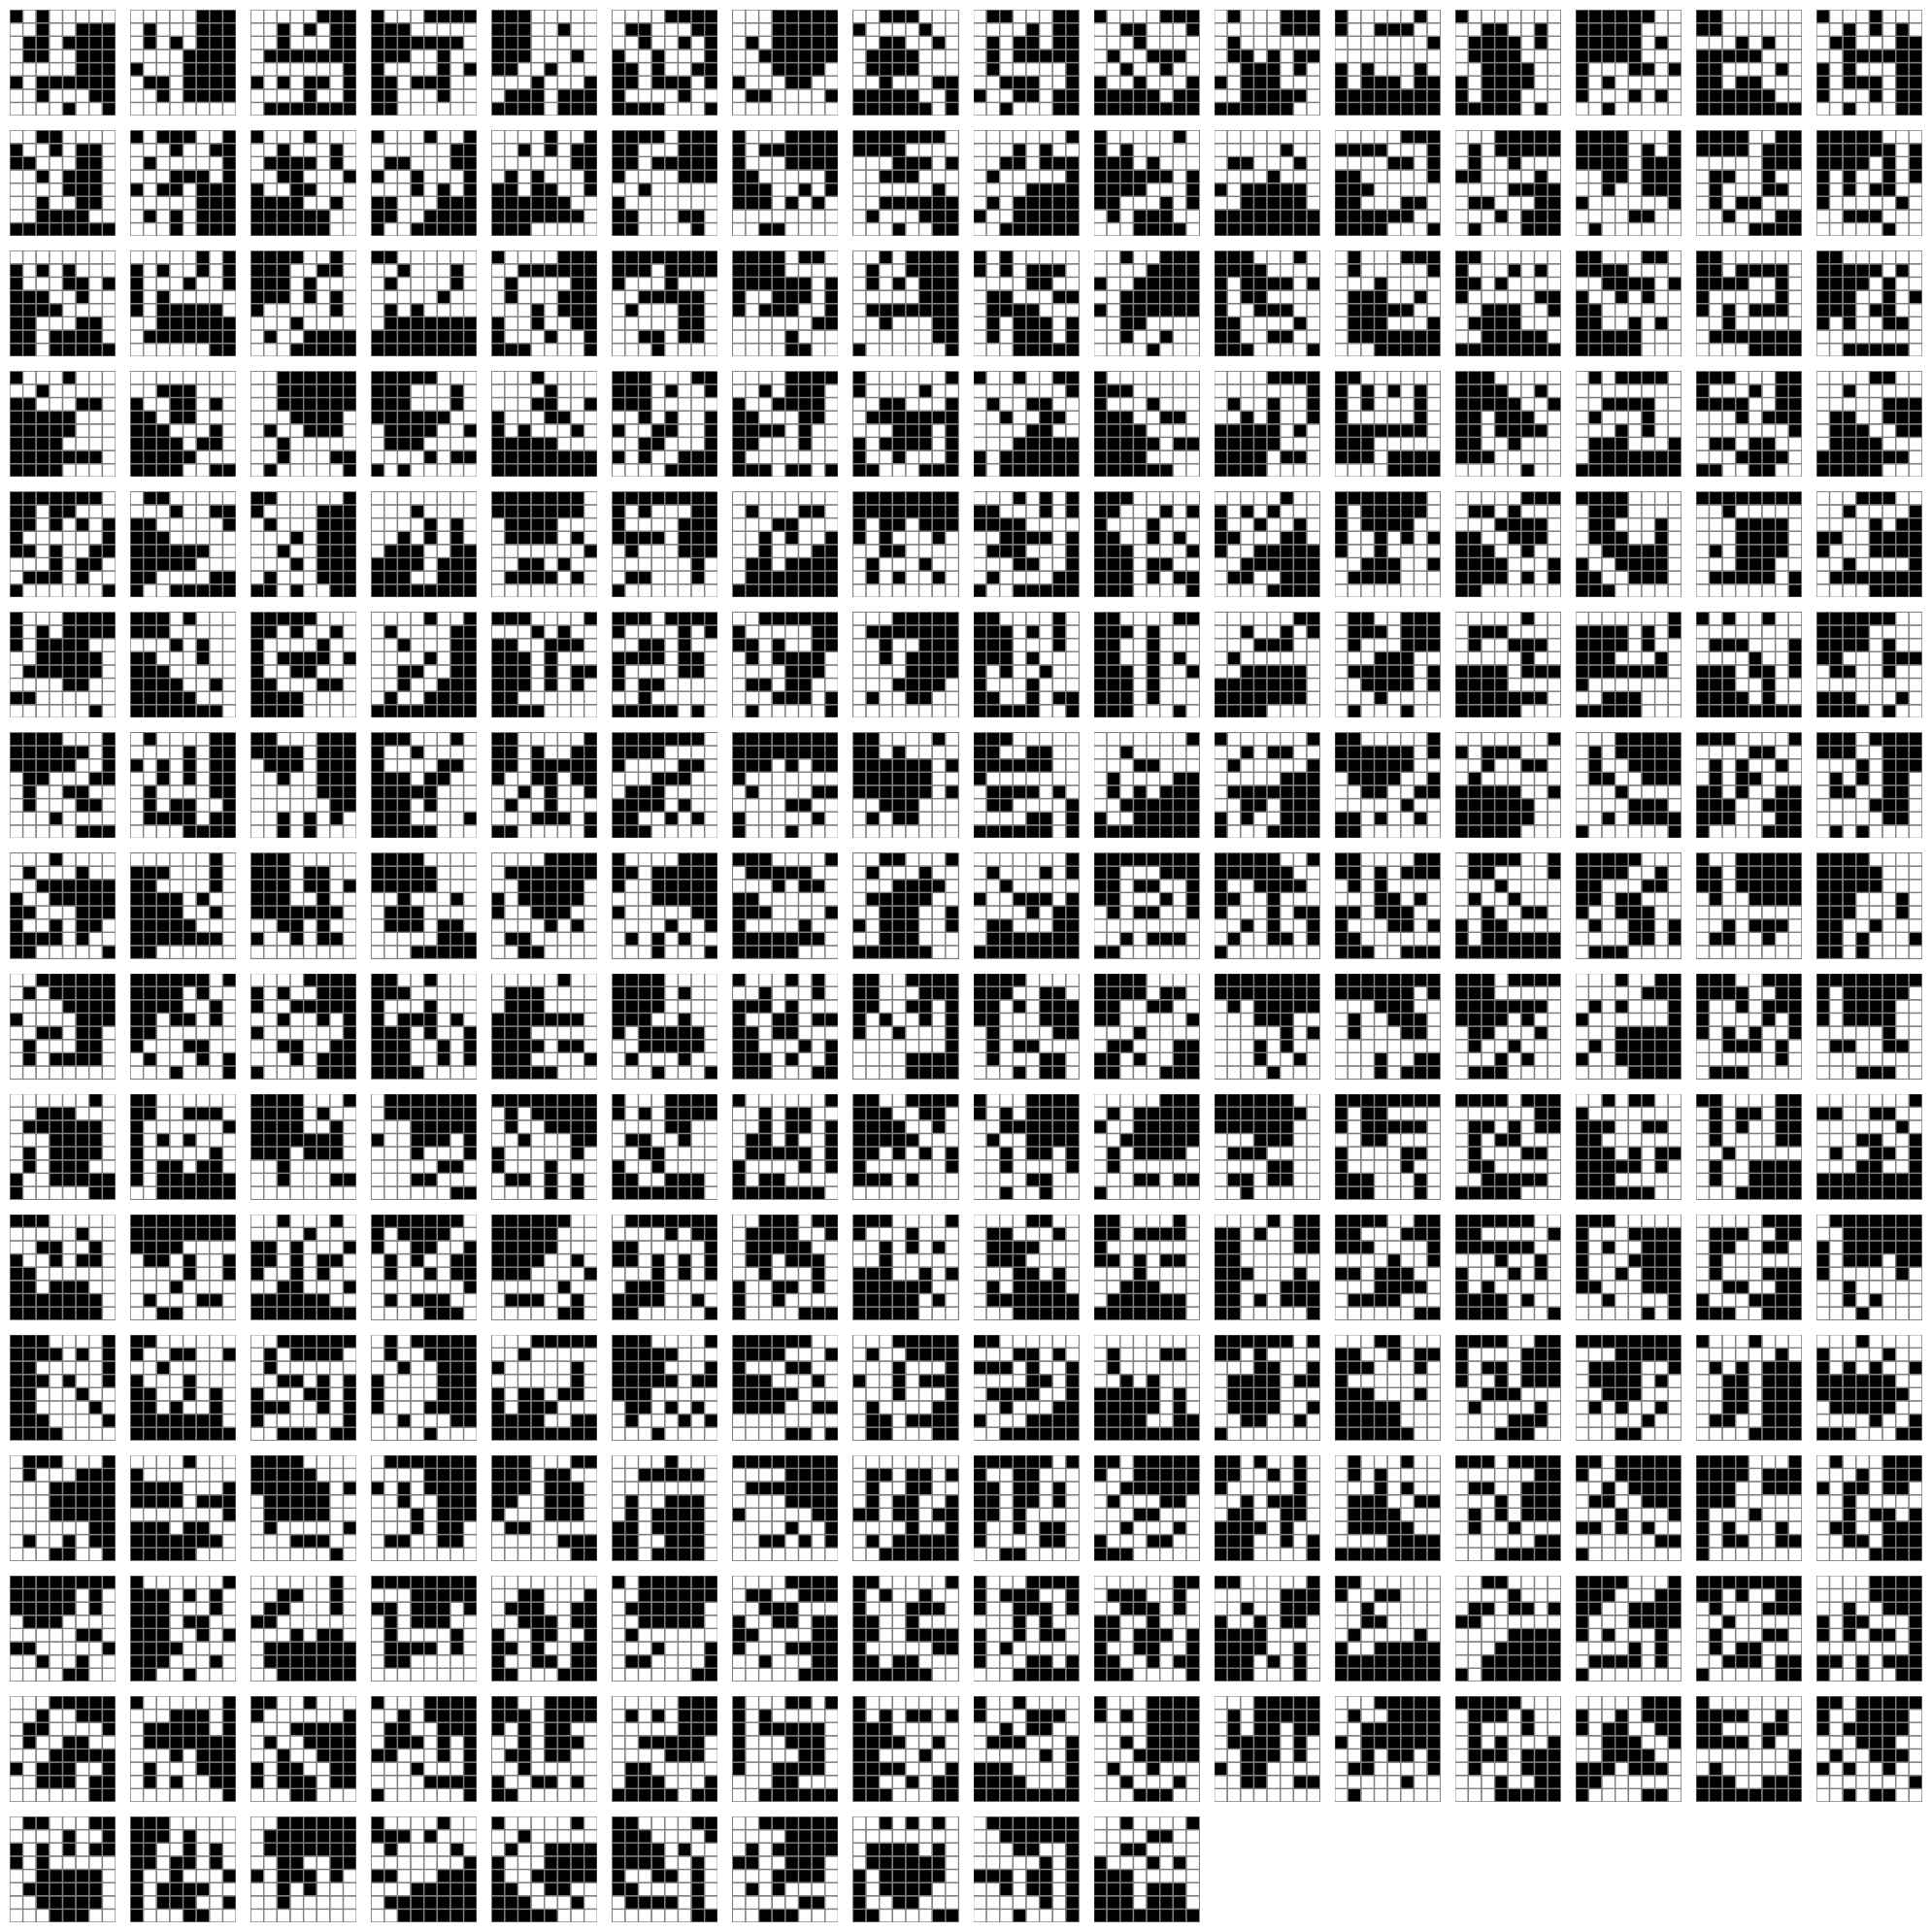

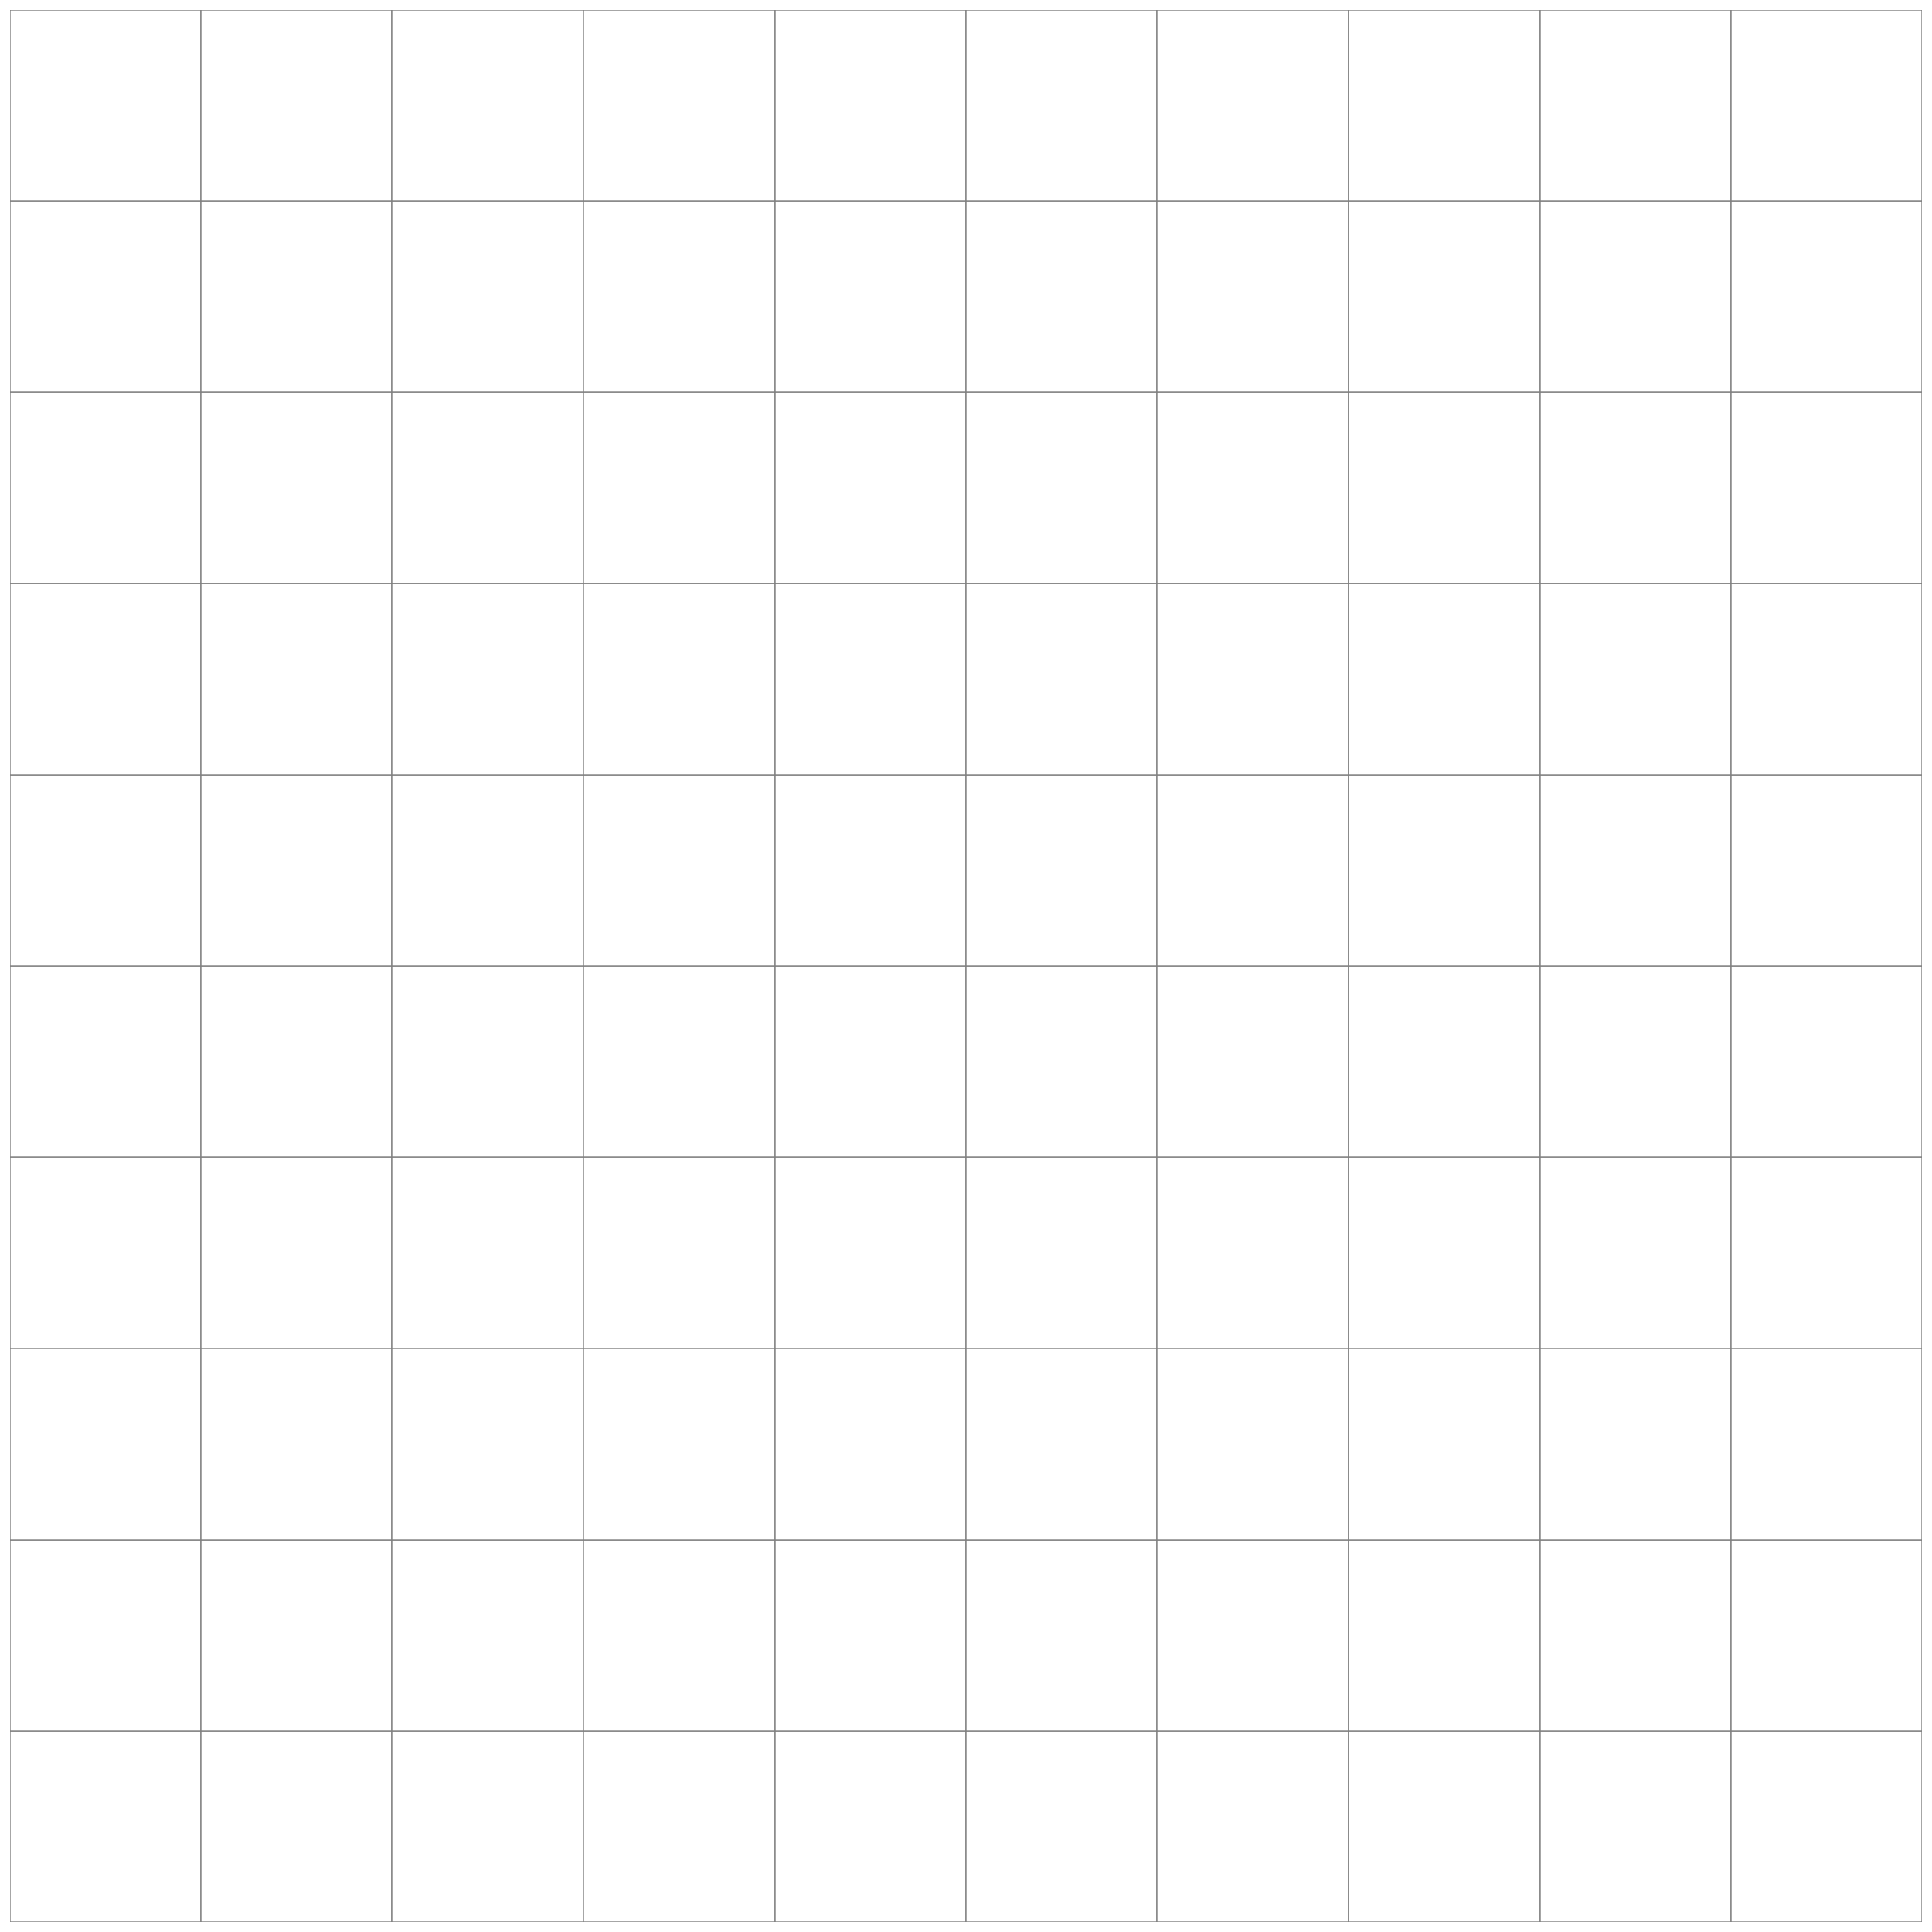

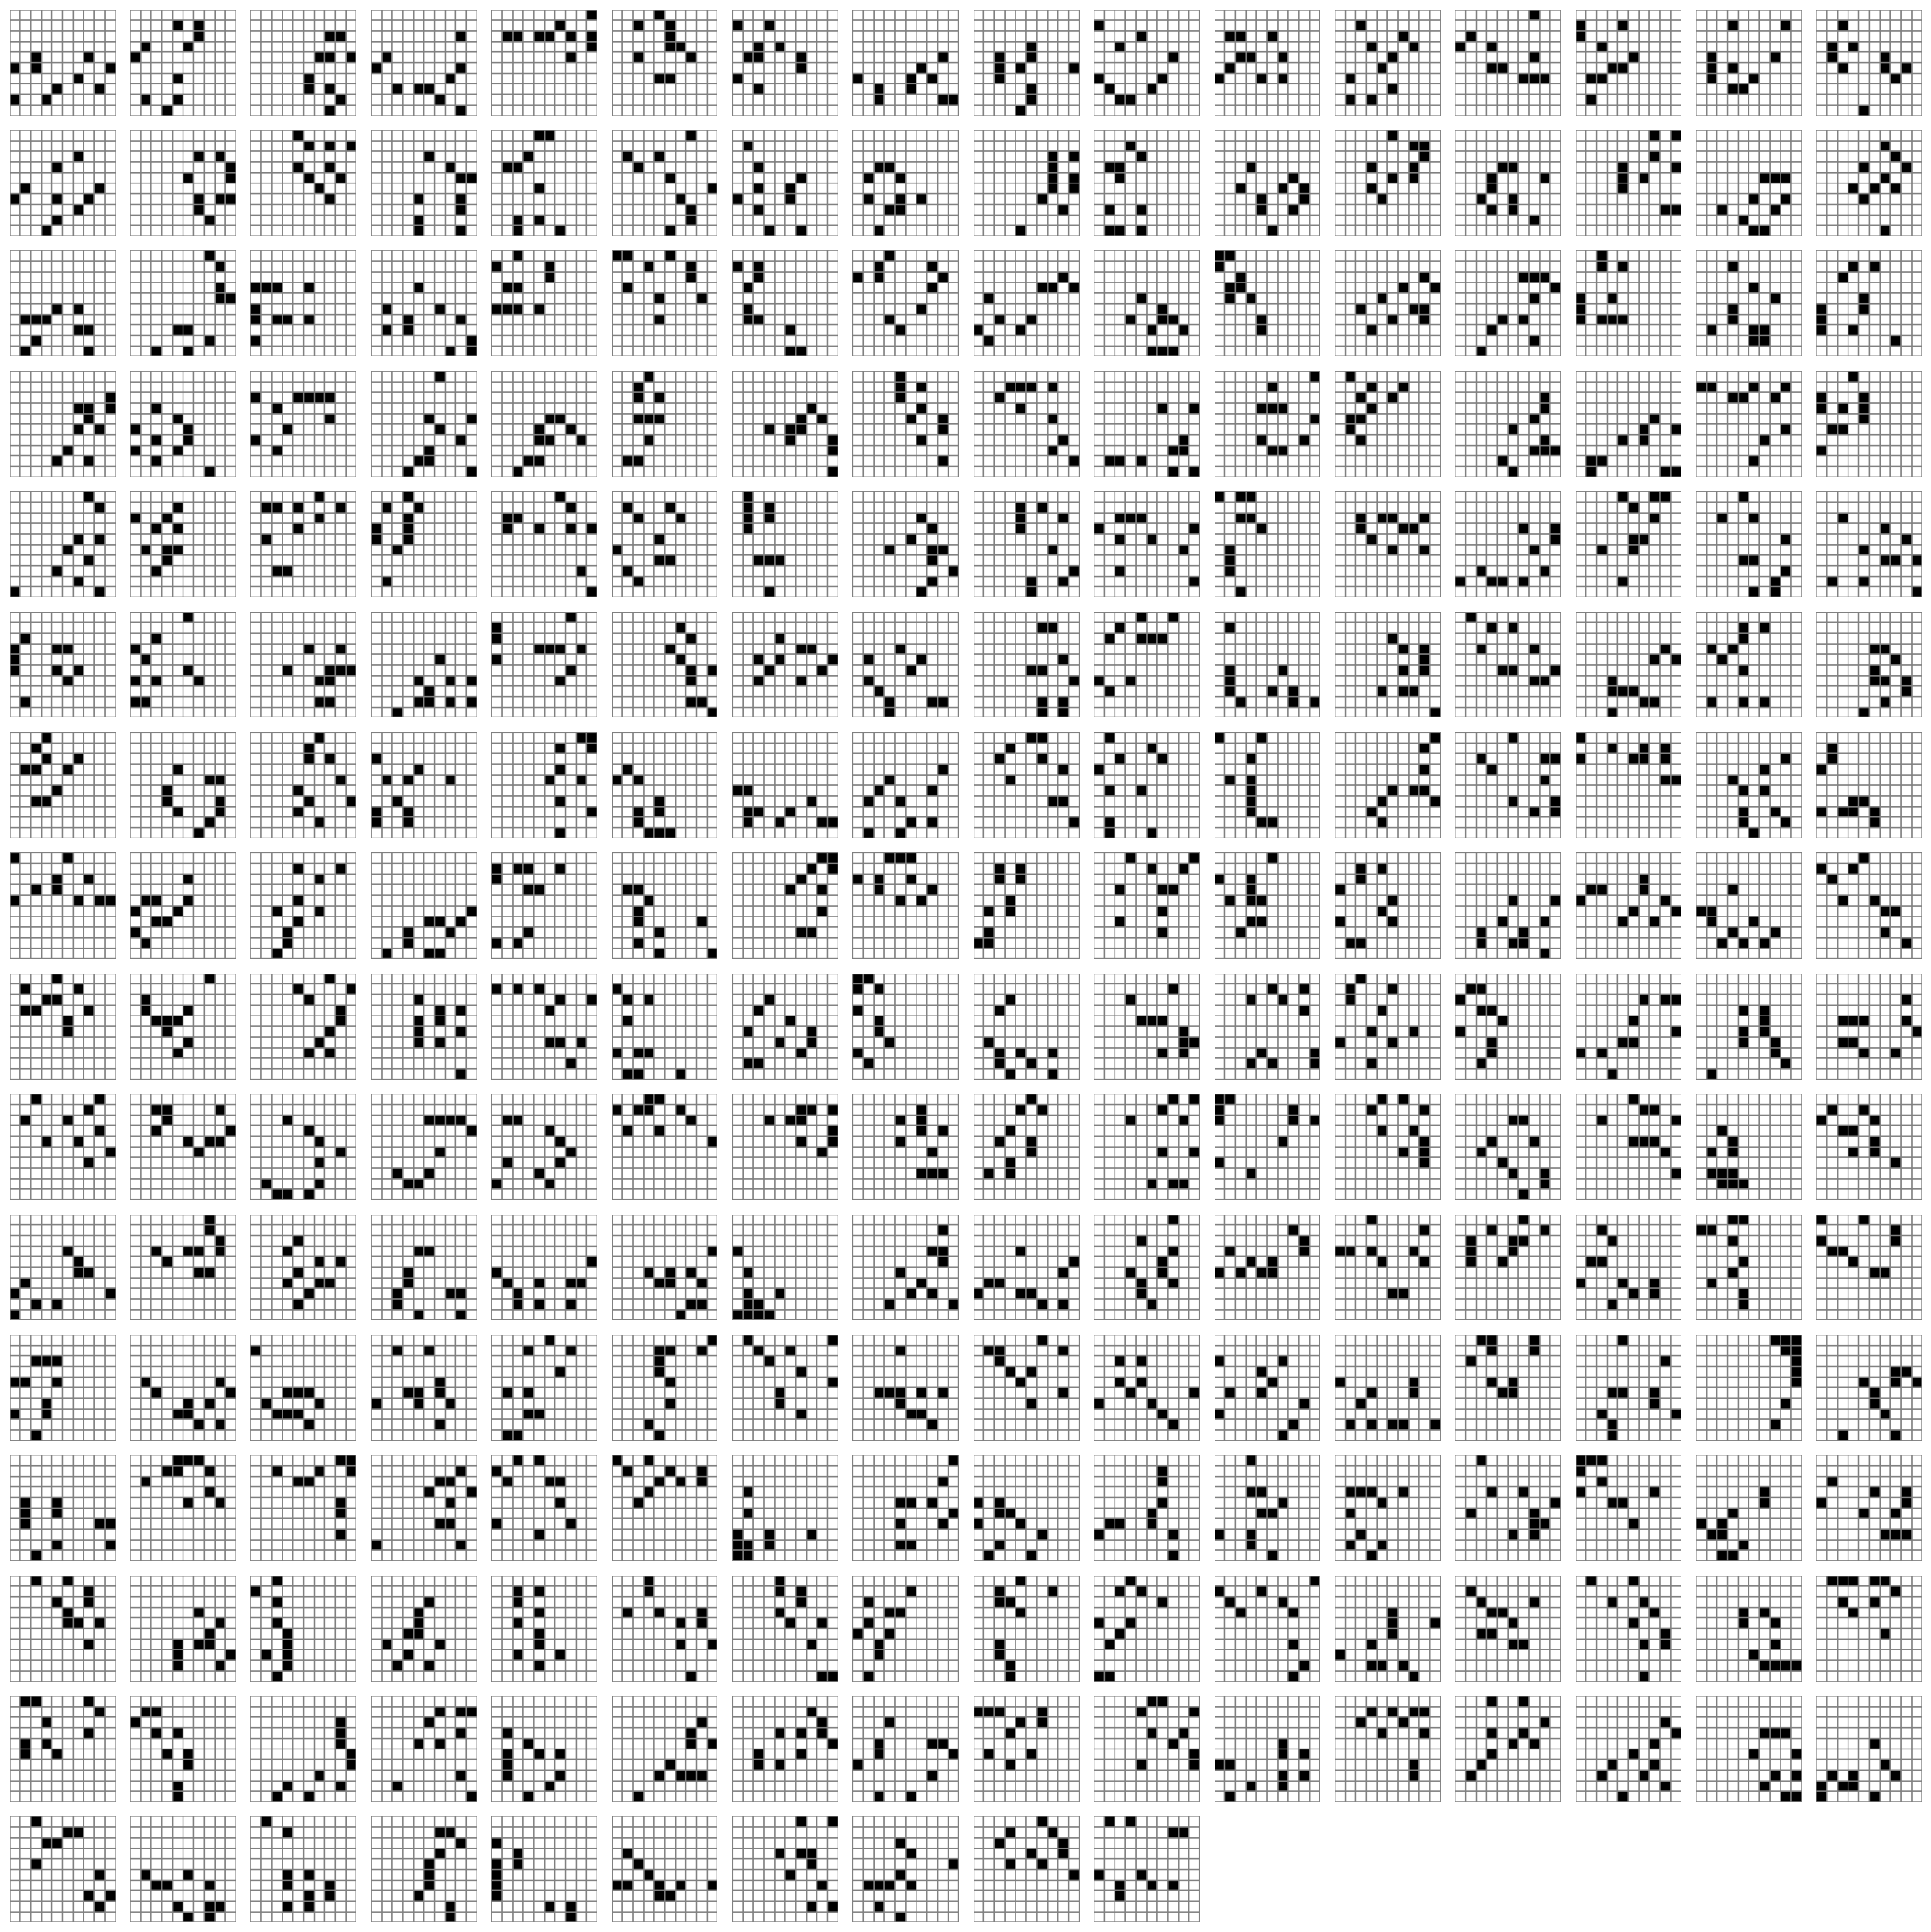

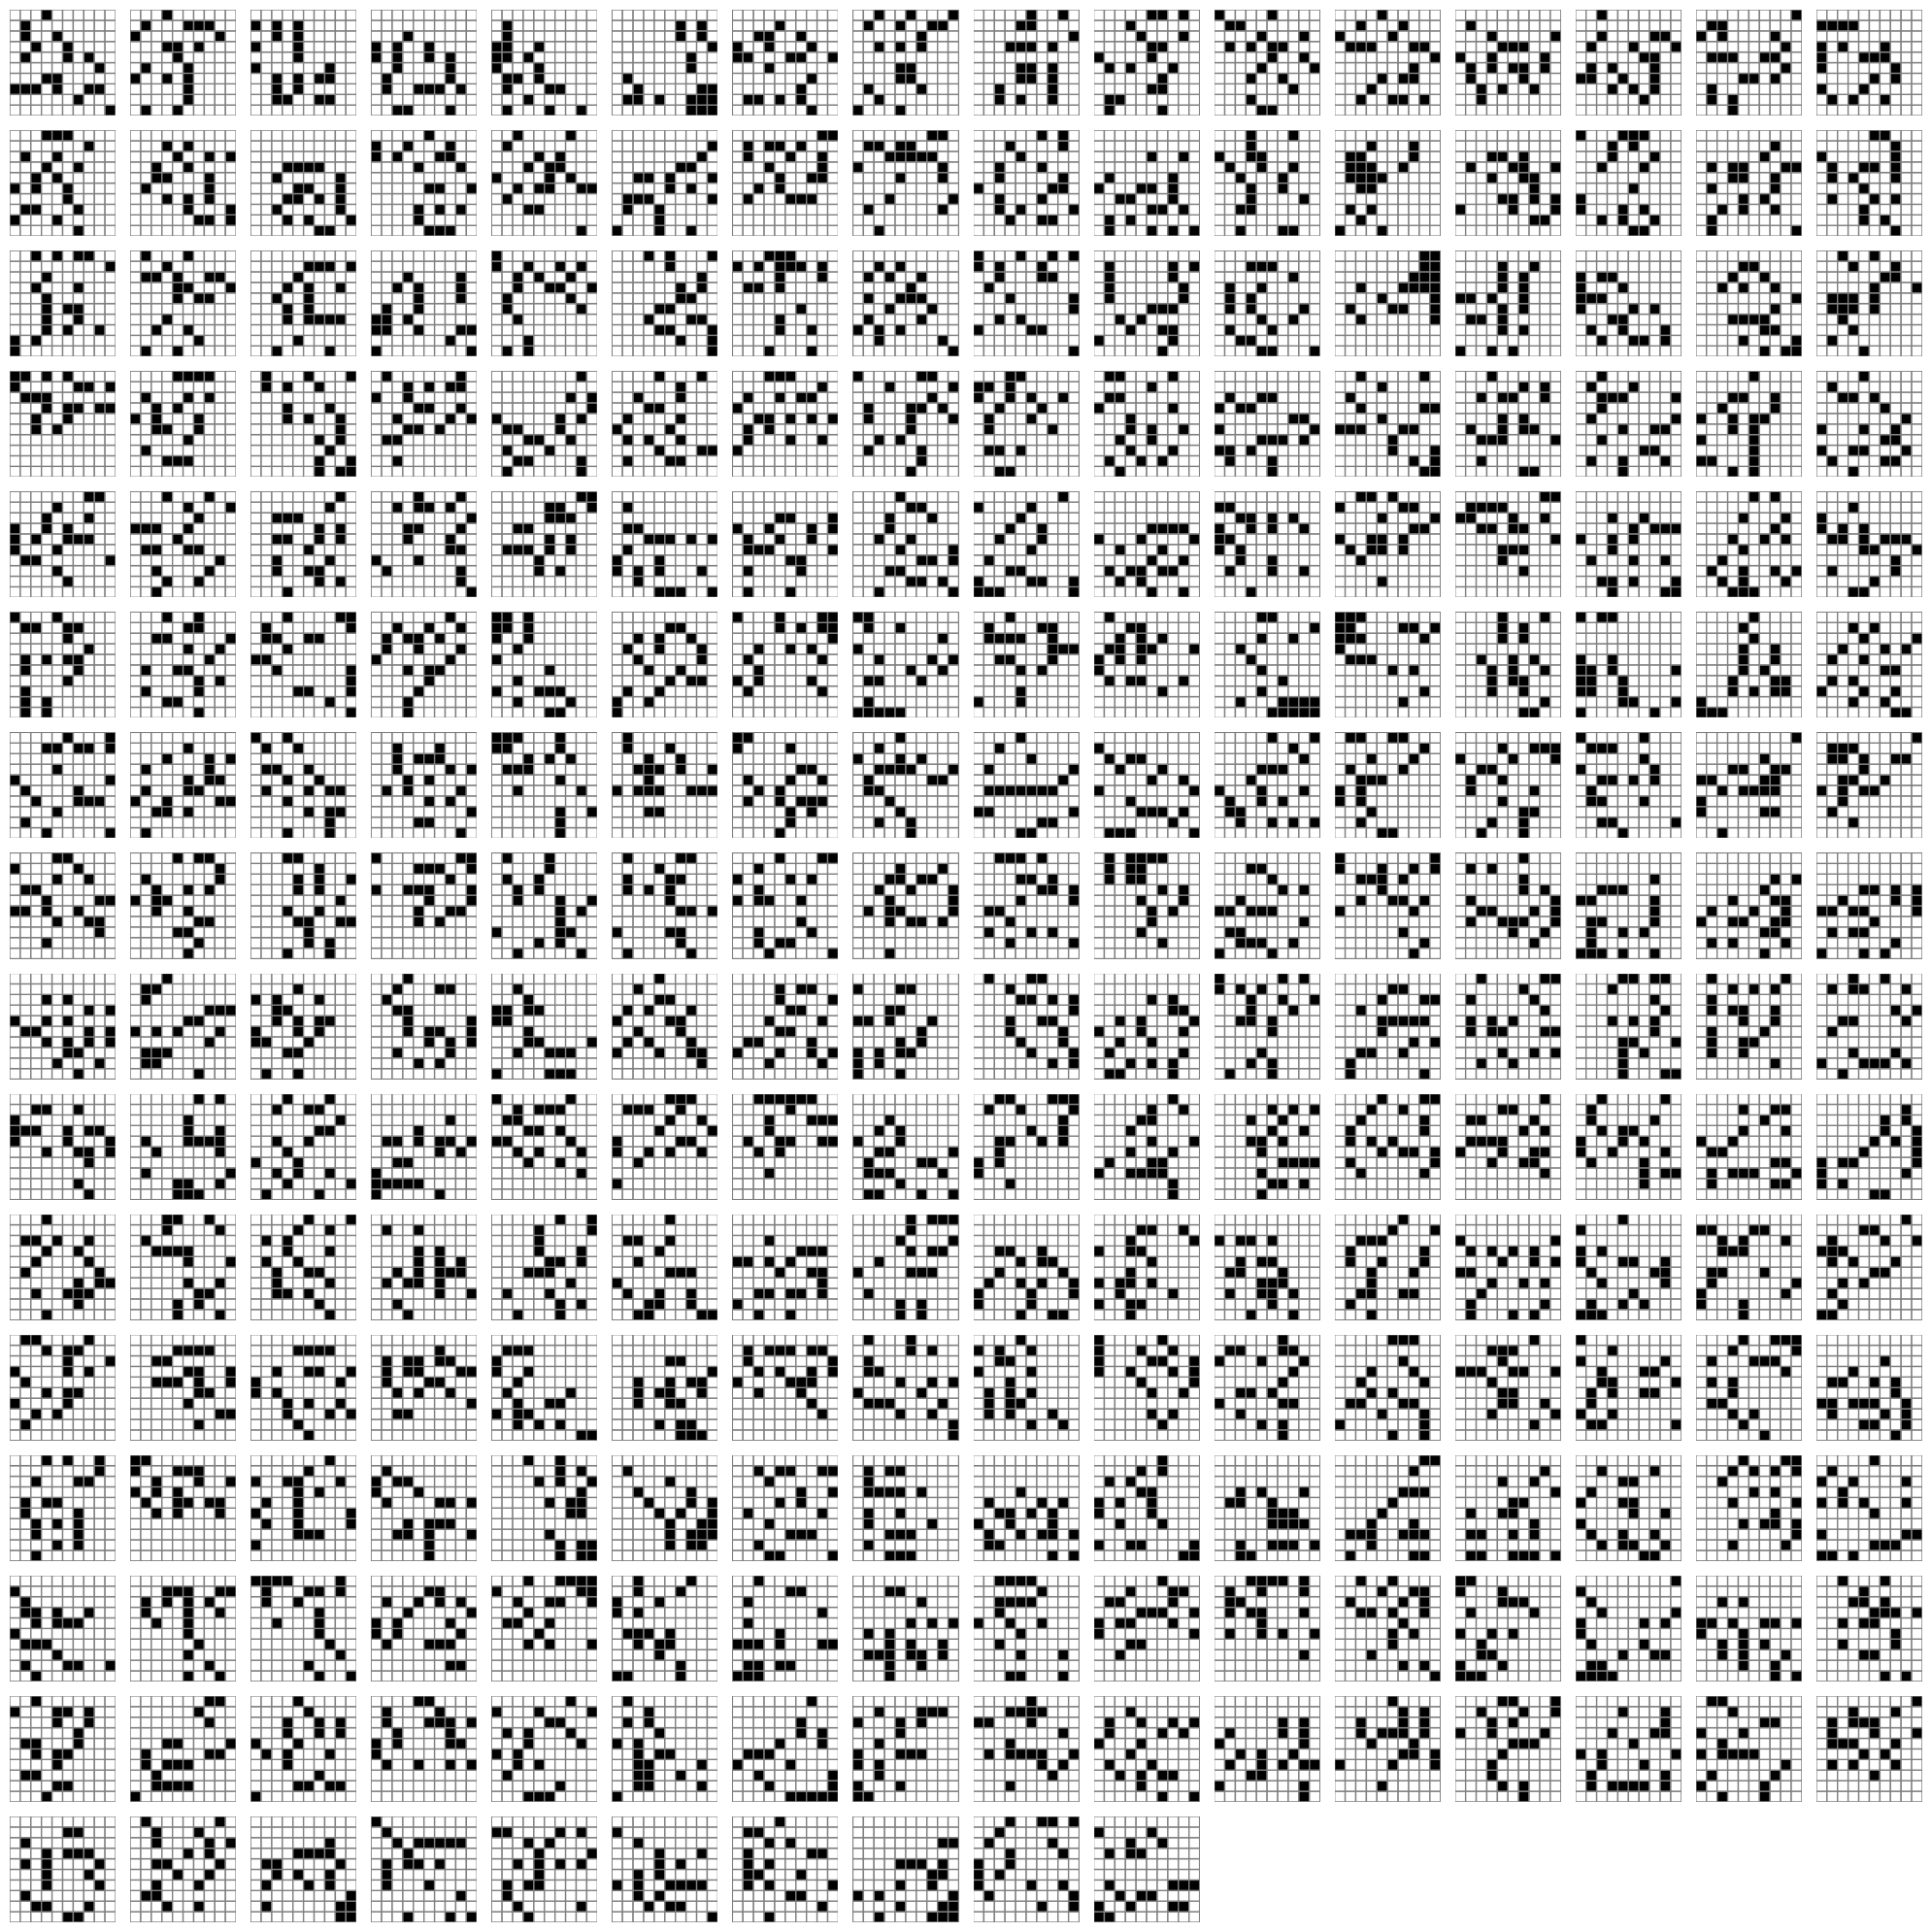

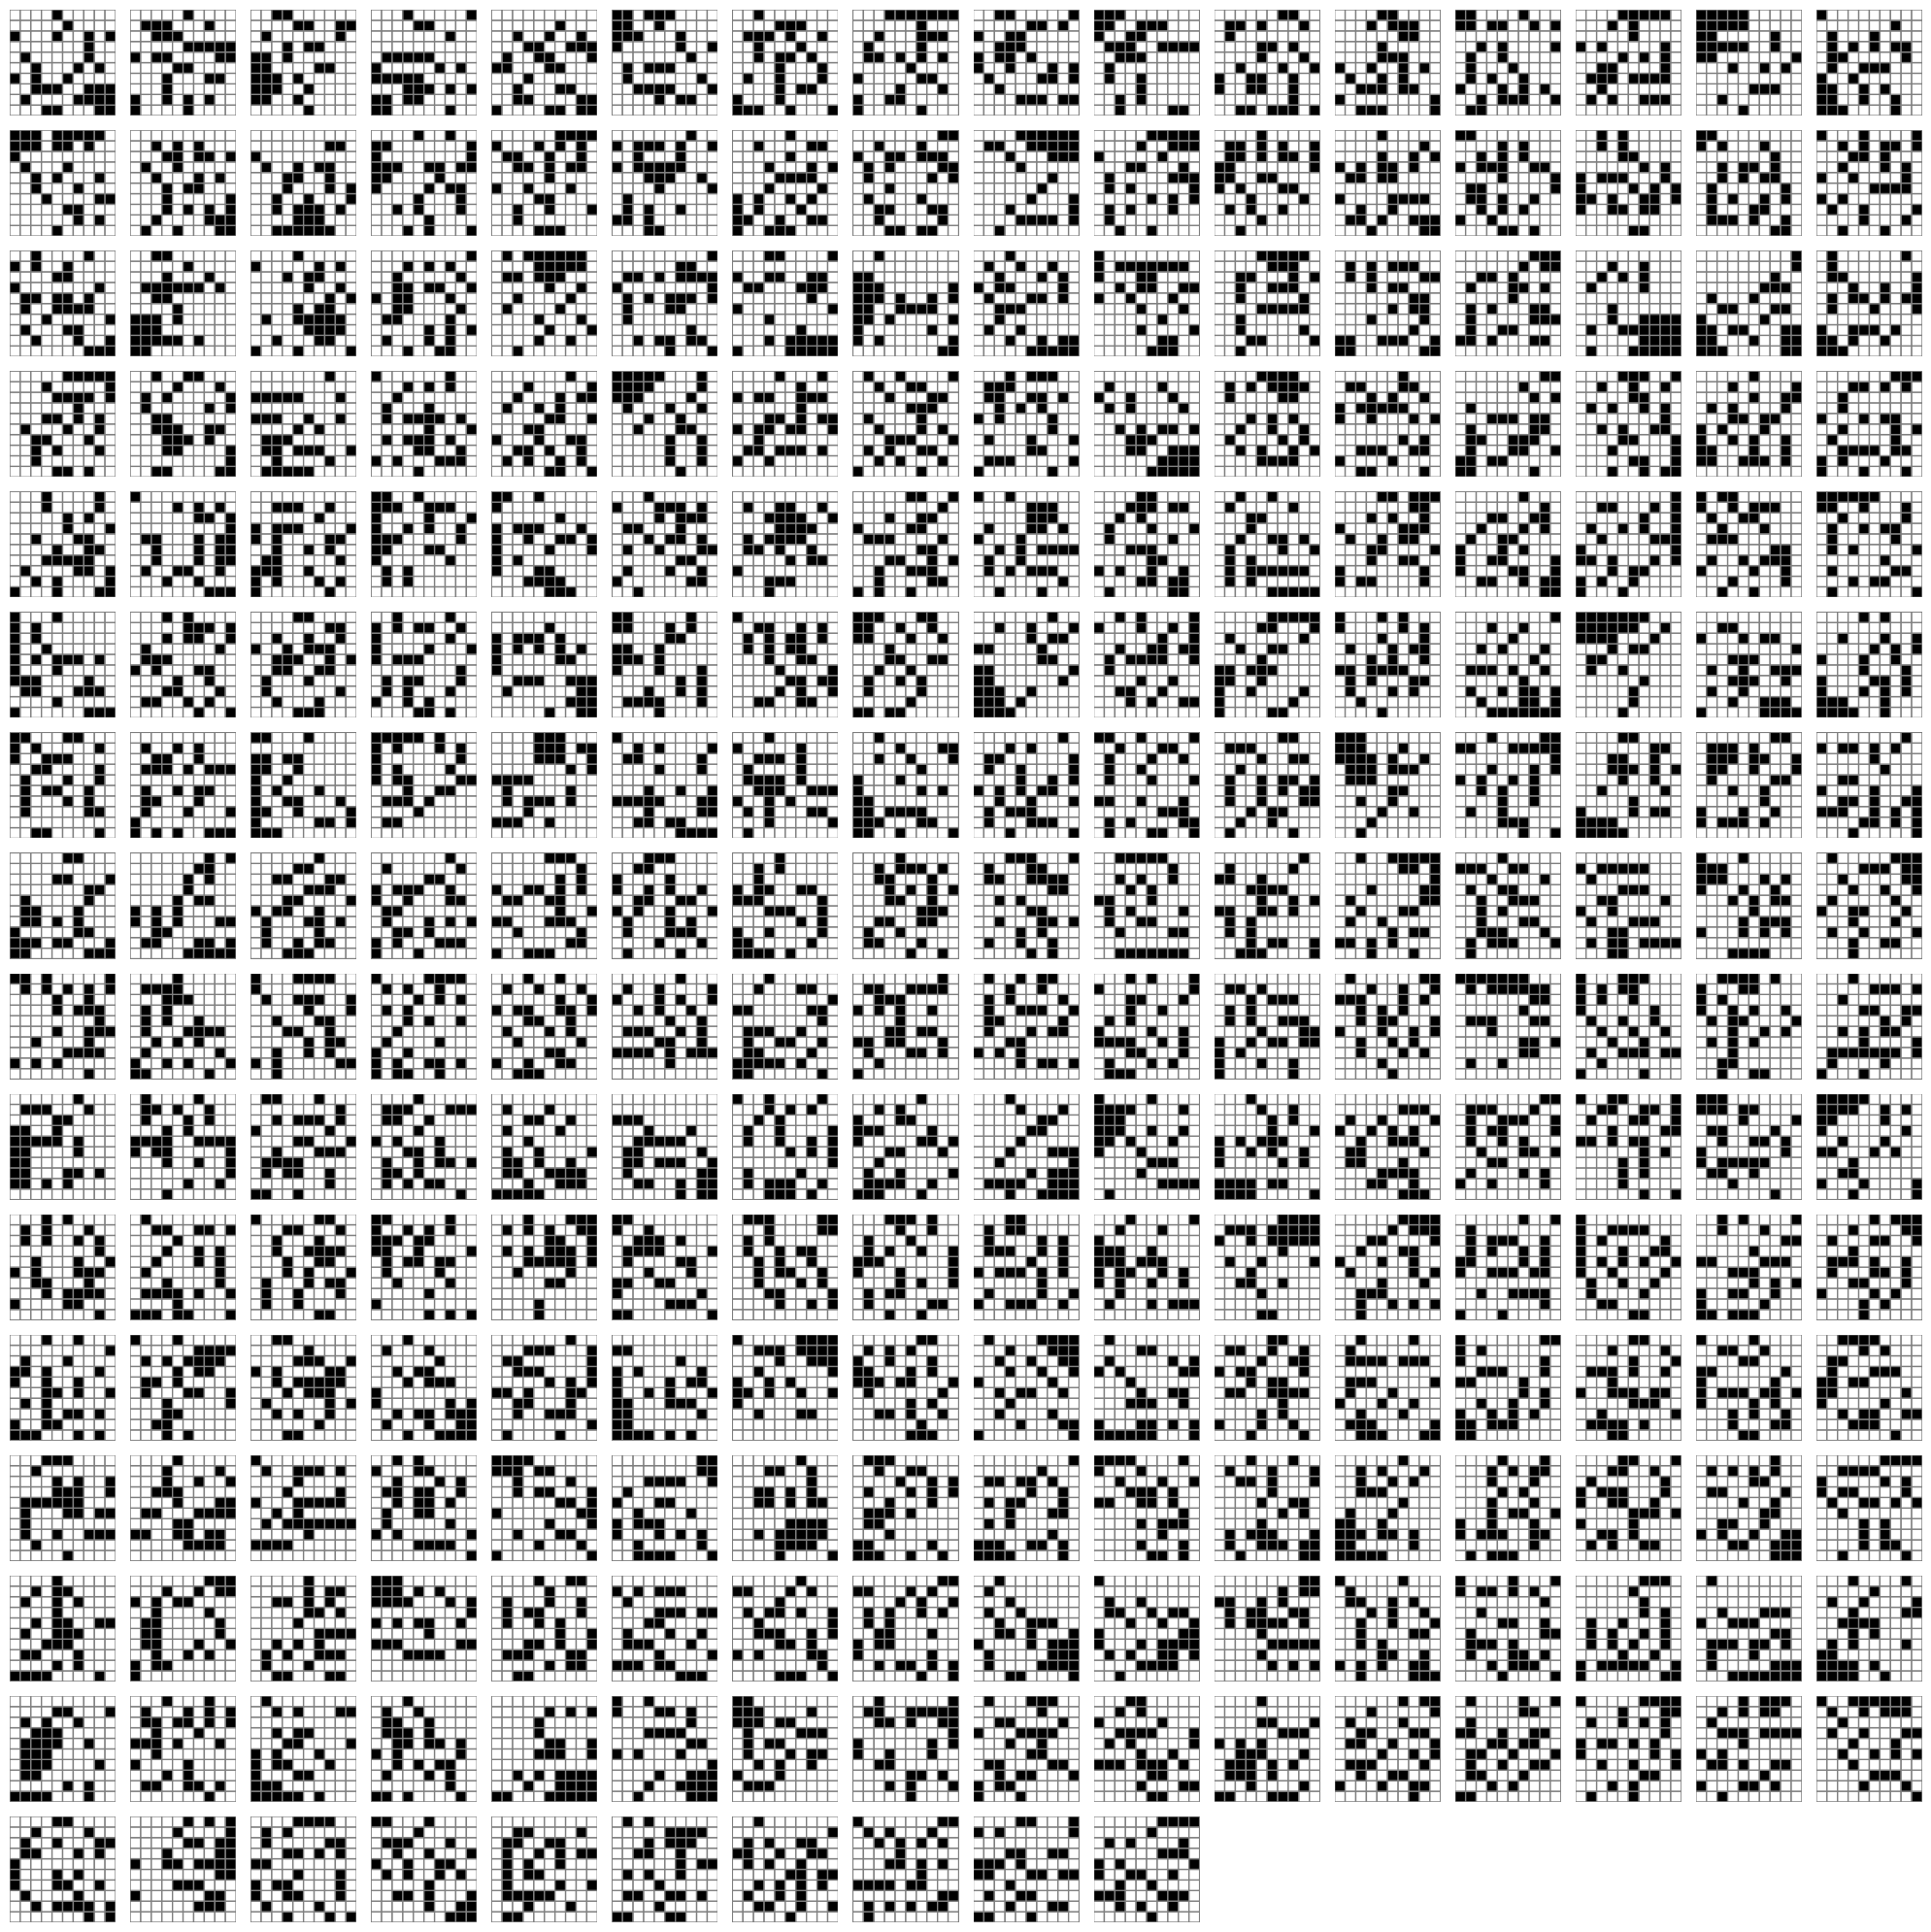

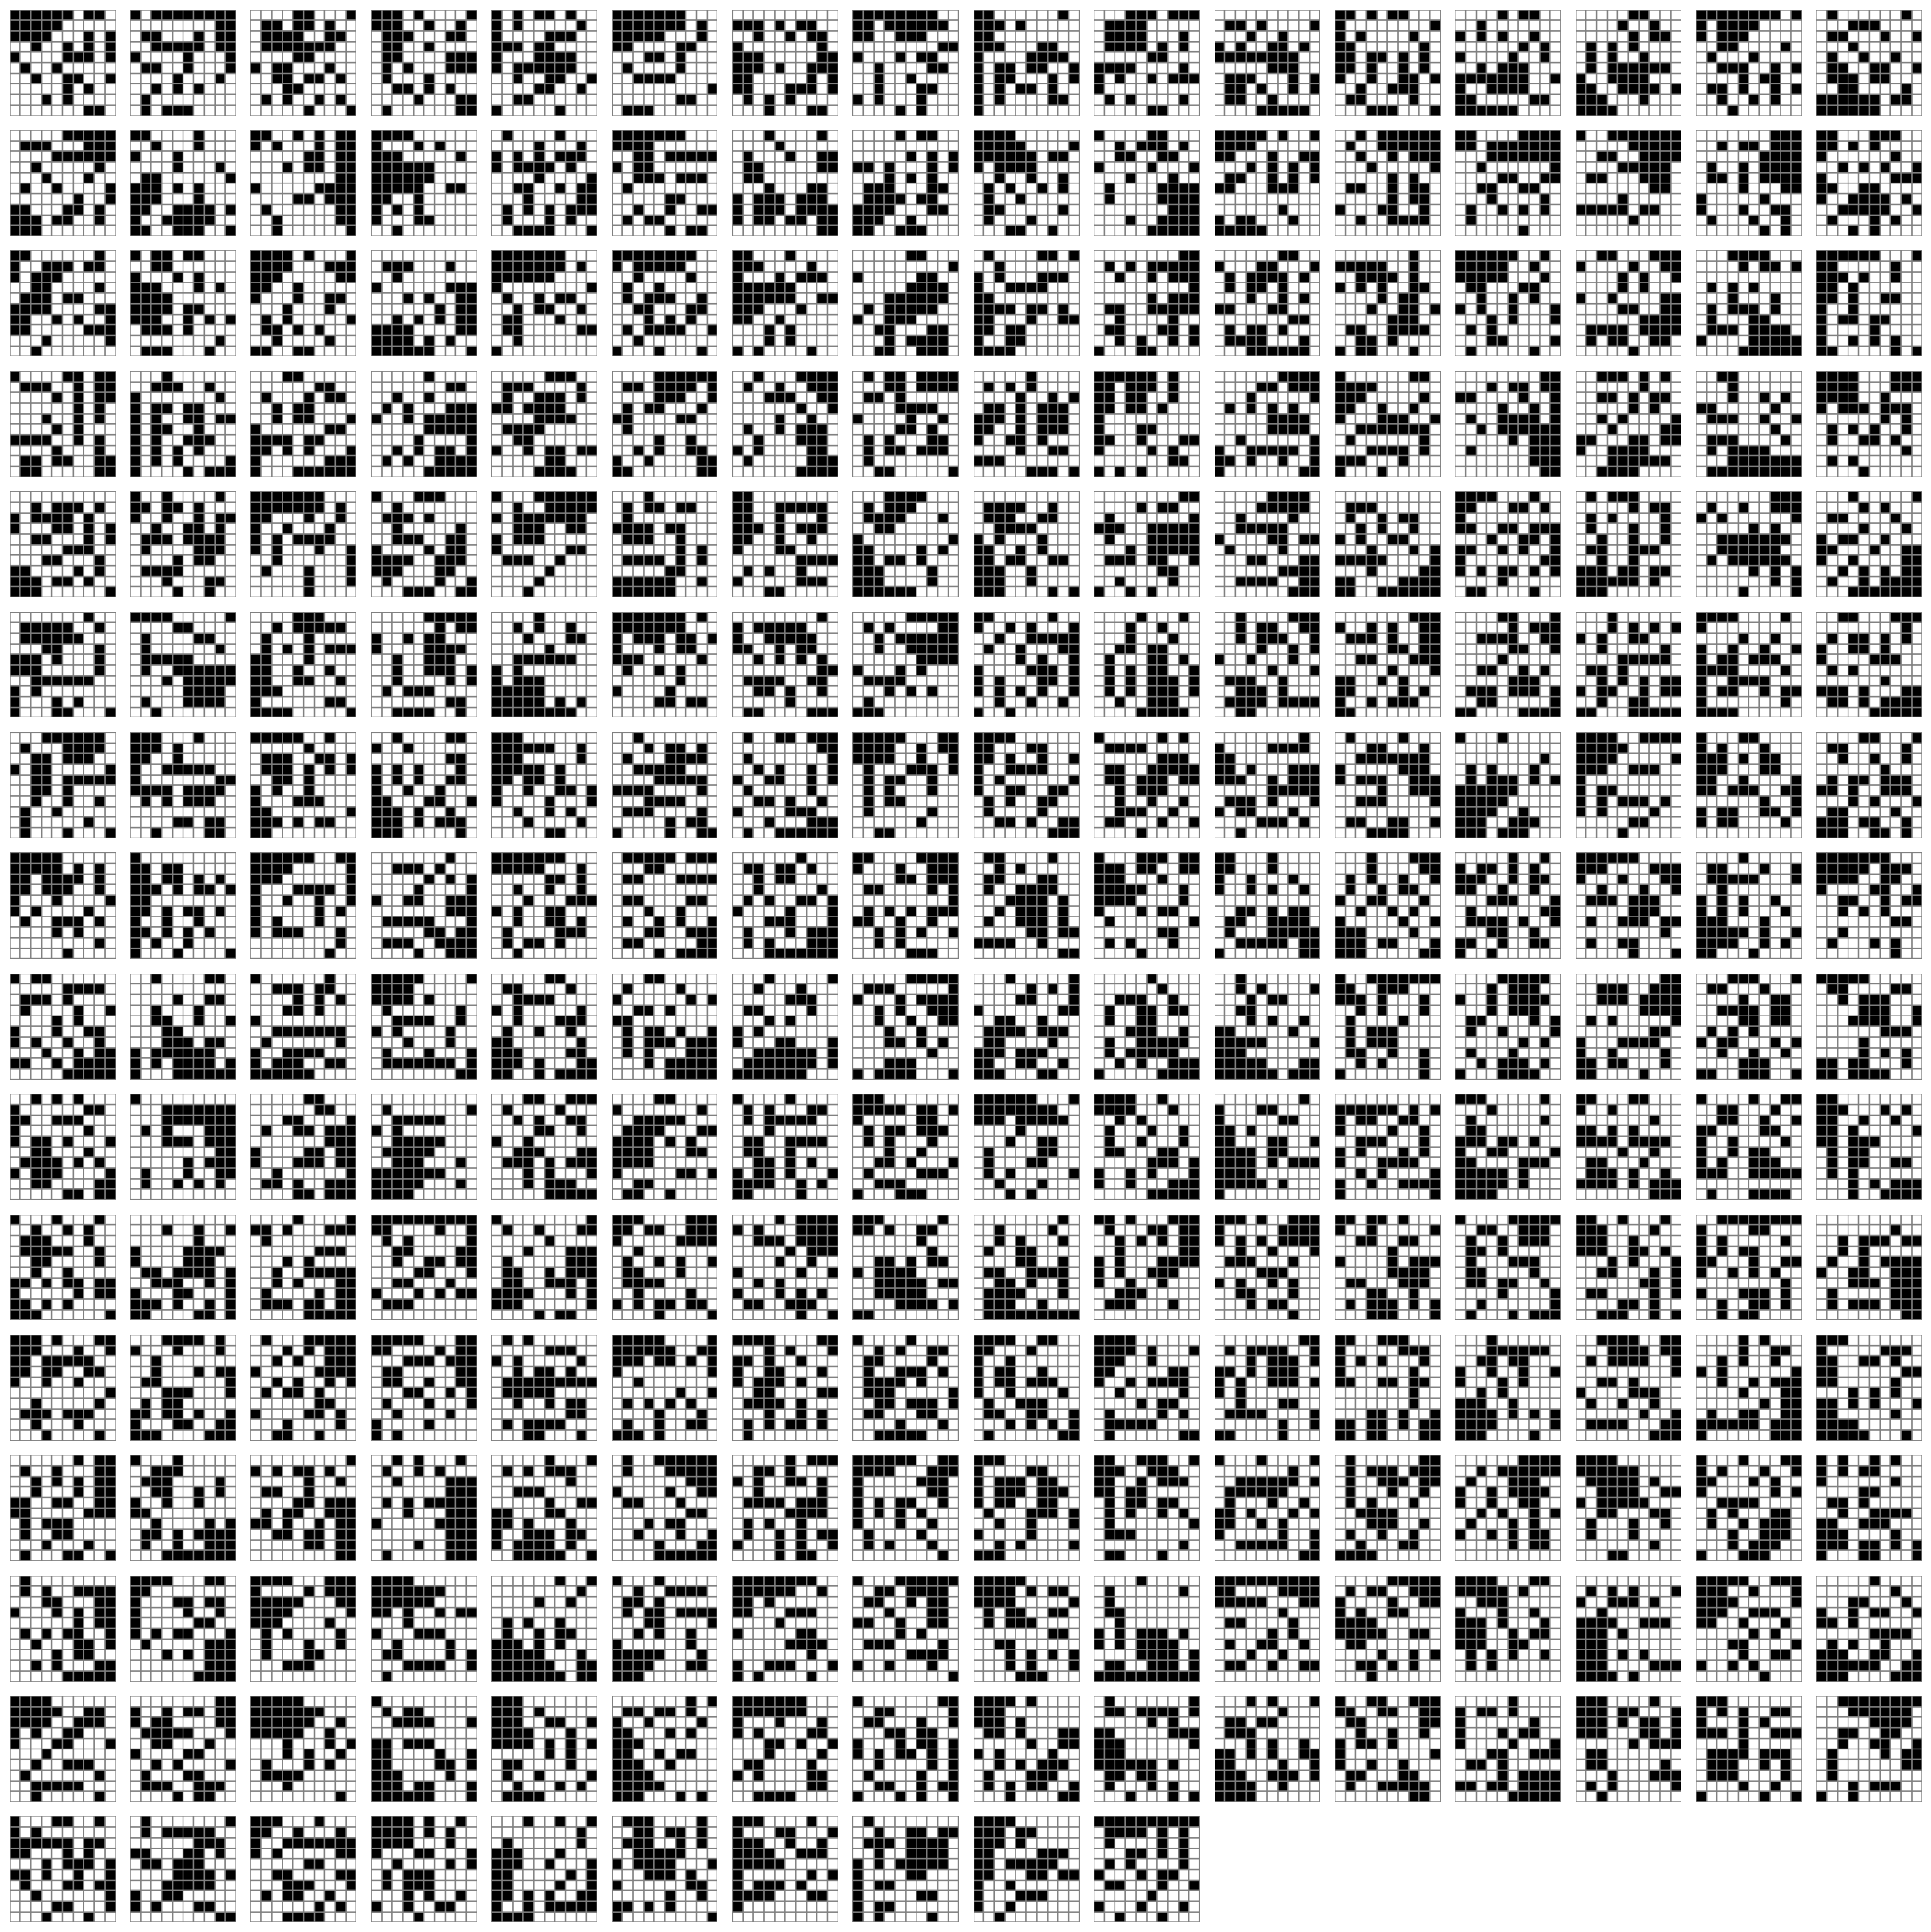

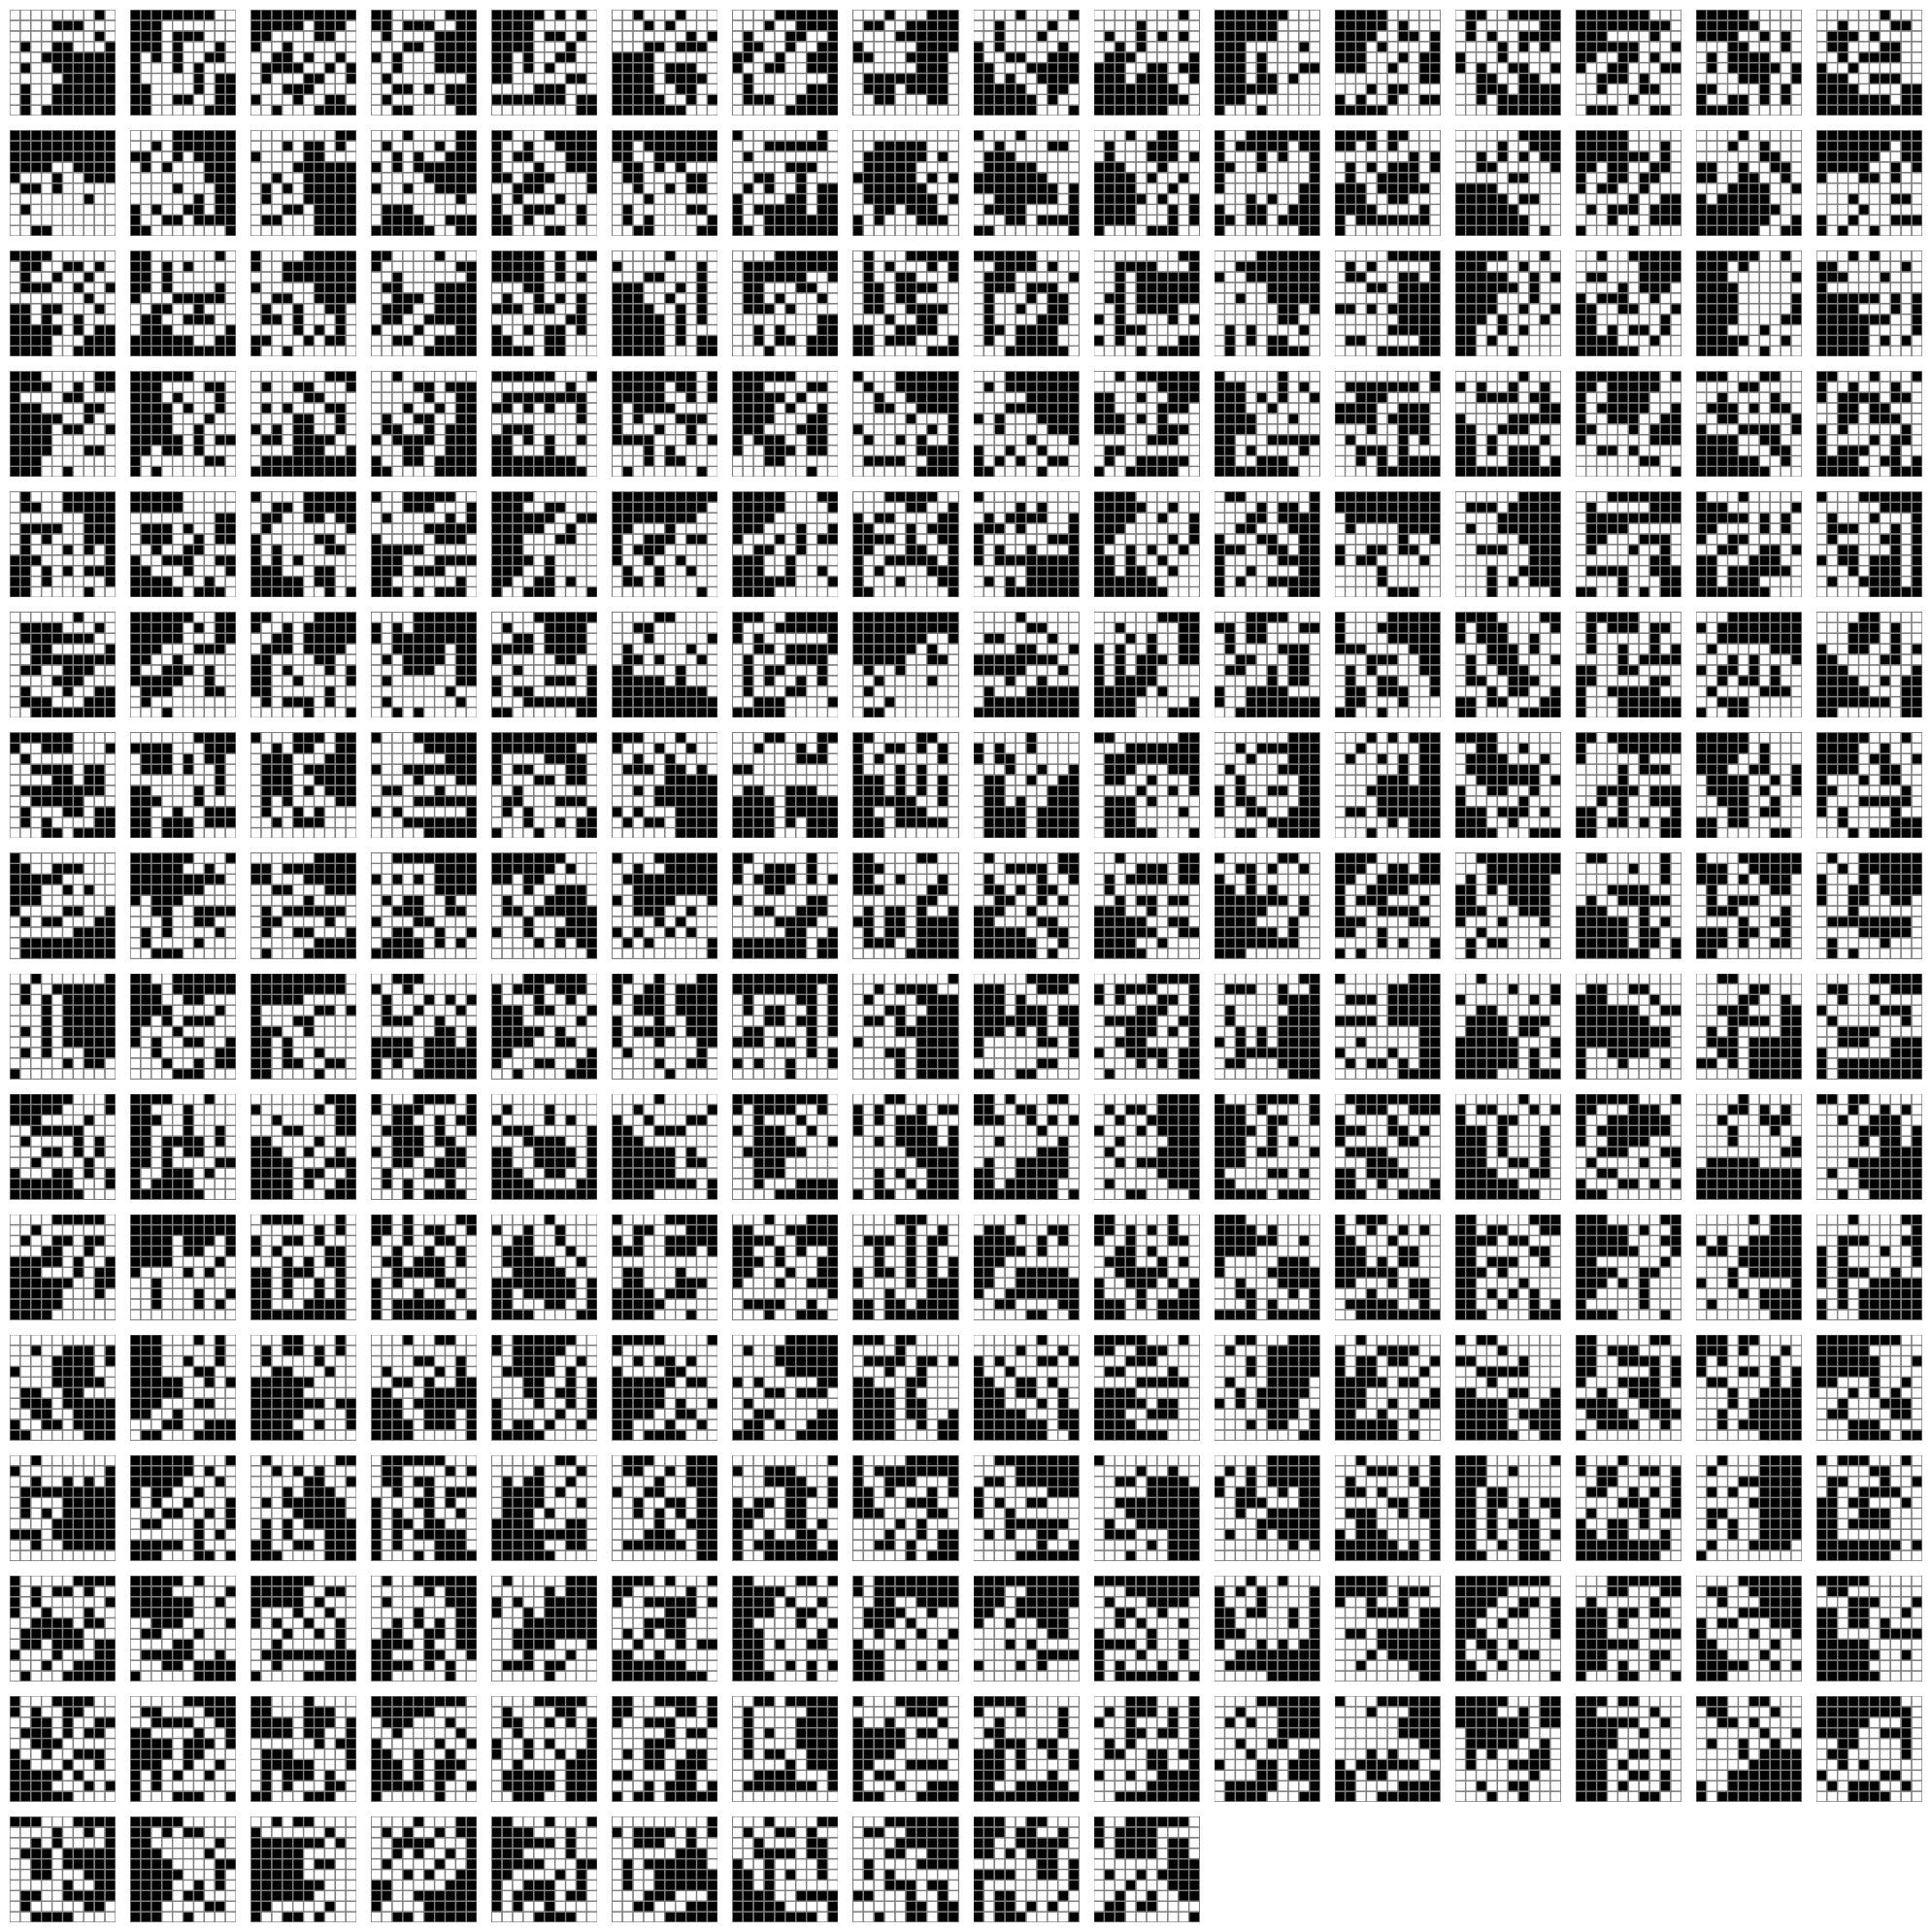

In [3]:
for rows in [6,8,10]:
    for obs_perc in [0, 10, 20, 30, 40, 50]:
        maps_set = set()
        maps = []
        with open(f'/Users/mattiachiari/Desktop/Lavoro/HumanGR/data/maps/maps_{rows}x{rows}_{obs_perc}.json', 'r') as f:
            lines = f.readlines()
            for line in [lines[i] for i in range(len(lines)) if i % 20 == 0]:
                map = np.asarray(json.loads(line)['map'])
                if tuple(map.flatten()) not in maps_set:
                    maps_set.add(tuple(map.flatten()))
                    maps.append(map)
                else:
                    print(f'Duplicate map found! {json.loads(line)["problem"]}')
        plot_maps(maps, None)